Recordar consultar el [Diccionario de datos](./Datasets/Google%20Maps/Diccionario%20de%20datos.docx)


# Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ast
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
import geojson
from textblob import TextBlob

# Llamado de datos a dataframes

In [2]:
df_maps_restaurantes = pd.read_parquet(r'Generated\Google\metada_sitios.parquet')
df_maps_reviews = pd.read_parquet(r'Generated\Google\merge_site_reviews.parquet')
df_yelp_restaurantes = pd.read_parquet(r'Generated\Yelp\bussines.parquet')
df_yelp_checkin = pd.read_parquet(r'Generated\YELP\business_checkin.parquet')
df_yelp_tips = pd.read_parquet(r'Generated\Yelp\business_tip.parquet')
df_yelp_reviews = pd.read_parquet(r'Generated\Yelp\review.parquet')
df_yelp_users = pd.read_parquet(r'Generated\Yelp\users_extracted.parquet')

In [3]:
df_maps_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212014 entries, 0 to 212013
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              212014 non-null  object 
 1   address           210956 non-null  object 
 2   gmap_id           212014 non-null  object 
 3   description       72392 non-null   object 
 4   latitude          212014 non-null  float64
 5   longitude         212014 non-null  float64
 6   category          212014 non-null  object 
 7   avg_rating        212014 non-null  float64
 8   num_of_reviews    212014 non-null  int64  
 9   price             100000 non-null  object 
 10  hours             189913 non-null  object 
 11  MISC              210599 non-null  object 
 12  state             190751 non-null  object 
 13  relative_results  170957 non-null  object 
 14  url               212014 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 24.3+ MB


In [4]:
df_maps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393452 entries, 0 to 2393451
Data columns (total 26 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   name_x            object 
 2   time              int64  
 3   rating            int64  
 4   text              object 
 5   pics              object 
 6   resp              object 
 7   gmap_id           object 
 8   anio              int64  
 9   estado            object 
 10  name_y            object 
 11  address           object 
 12  description       object 
 13  latitude          float64
 14  longitude         float64
 15  category          object 
 16  avg_rating        float64
 17  num_of_reviews    int64  
 18  price             object 
 19  hours             object 
 20  MISC              object 
 21  state             object 
 22  relative_results  object 
 23  url               object 
 24  state_ab          object 
 25  us_state          object 
dtypes: float64(3),

# Google Maps Cadenas

Comenzaremos limpiando los dataframes de Reviews y Restaurantes de Google Maps


In [5]:
df_maps_restaurantes.isnull().sum()

name                     0
address               1058
gmap_id                  0
description         139622
latitude                 0
longitude                0
category                 0
avg_rating               0
num_of_reviews           0
price               112014
hours                22101
MISC                  1415
state                21263
relative_results     41057
url                      0
dtype: int64

crearemos dos funciones que serviran para  arreglar los errores de computo dentro de los estados, estos codigos utilian las coordenadas y unos diccionarios con la informacion para computar el valor correcto

In [6]:
state_abreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", 
    "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", 
    "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", 
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", 
    "WI", "WY"
]

state_dictionary = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", 
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DC":"District of Columbia","DE": "Delaware", 
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", 
    "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", 
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", 
    "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri", "MT": "Montana", 
    "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", 
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", 
    "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", 
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee", 
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington", 
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

state_dictionary_inv = dict(zip(state_dictionary.values(), state_dictionary.keys()))

state_index = pd.read_csv('2014_usa_states.csv', dtype={'Rank': 'int'}, index_col='Rank')[['State']]['State'].to_dict()

with open(r'Geojson\us-states.json', 'r') as f:
    data_geo_1 = geojson.load(f)
    
def get_state_1(lat, lon):
    # print([lat, lon])
    for i in range(len(data_geo_1['features'])):
        try:
            coordinates = data_geo_1['features'][i]['geometry']['coordinates'][0] 
            polygon = Polygon(coordinates)

            if polygon.contains(Point(lon, lat)):
                return state_dictionary_inv[data_geo_1['features'][i].properties['name']]
        except:
            pass
    return None

with open('geojson-counties-fips.json', 'r') as f:
    data_geo_2 = geojson.load(f)
    
def get_state_2(lat, lon):
    for feature in data_geo_2['features']:
        try:
            geometry_type = feature['geometry']['type']
            
            if geometry_type == 'Polygon':
                coordinates = feature['geometry']['coordinates'][0]
                polygon = Polygon(coordinates)
                if polygon.contains(Point(lon, lat)):
                    return state_dictionary_inv[state_index[int(feature['properties']['STATE'])]]
                
            elif geometry_type == 'MultiPolygon':
                for polygon_coords in feature['geometry']['coordinates']:
                    polygon = Polygon(polygon_coords[0])
                    if polygon.contains(Point(lon, lat)):
                        return state_dictionary_inv[state_index[int(feature['properties']['STATE'])]]
                
        except (KeyError, IndexError):
            return None
    
    return None

def get_state_ab(address):
    try:
        state = address.split(', ')[-1].split(' ')[0]
        if state in state_abreviations:
            return state
        else:
            return np.nan
    except:
        return np.nan
    

Sometemos el dataframe reviews a estas formulas

In [7]:
#null_state_rows = df_maps_reviews['state_ab'].isnull()
#df_maps_reviews.loc[null_state_rows, 'state_ab'] = df_maps_reviews[null_state_rows].apply(lambda row: get_state_1(row['latitude'], row['longitude']), axis=1)

In [8]:
#null_state_rows = df_maps_reviews['state_ab'].isnull()
#df_maps_reviews.loc[null_state_rows, 'state_ab'] = df_maps_reviews[null_state_rows].apply(lambda row: get_state_2(row['latitude'], row['longitude']), axis=1)

Completaremos los valores faltantes en MISC de subway, burguer king, Dunkin y Mc Donald´s con los valores de un MISC completo de sus respesctivos

Para eso primero obtenemos el valor, lo acomodamos para darle su formato diccionario y lo agregamos en donde haya nulos

In [9]:
subway_df = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains('subway')]
if not subway_df.empty:
    print(subway_df['MISC'].iloc[0])

# {'Accessibility': array(['Wheelchair accessible entrance'], dtype=object), 'Amenities': array(['Good for kids'], dtype=object), 'Atmosphere': array(['Casual'], dtype=object), 'Crowd': None, 'Dining options': array(['Lunch'], dtype=object), 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': array(['Fast service'], dtype=object), 'Offerings': array(['Healthy options', 'Quick bite'], dtype=object), 'Payments': array(['Debit cards', 'NFC mobile payments'], dtype=object), 'Planning': None, 'Popular for': array(['Lunch', 'Dinner', 'Solo dining'], dtype=object), 'Recycling': None, 'Service options': array(['Delivery', 'Takeout', 'Dine-in'], dtype=object)}

{'Accessibility': array(['Wheelchair accessible entrance'], dtype=object), 'Amenities': array(['Good for kids'], dtype=object), 'Atmosphere': array(['Casual'], dtype=object), 'Crowd': None, 'Dining options': array(['Lunch'], dtype=object), 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': array(['Fast service'], dtype=object), 'Offerings': array(['Healthy options', 'Quick bite'], dtype=object), 'Payments': array(['Debit cards', 'NFC mobile payments'], dtype=object), 'Planning': None, 'Popular for': array(['Lunch', 'Dinner', 'Solo dining'], dtype=object), 'Recycling': None, 'Service options': array(['Delivery', 'Takeout', 'Dine-in'], dtype=object)}


In [10]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance'], 'Amenities': ['Good for kids'], 'Atmosphere': ['Casual'], 'Crowd': None, 'Dining options': 'Lunch', 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': 'Fast service', 'Offerings':['Healthy options', 'Quick bite'], 'Payments':['Debit cards', 'NFC mobile payments'], 'Planning': None, 'Popular for': ['Lunch', 'Dinner', 'Solo dining'], 'Recycling': None, 'Service options': ['Delivery', 'Takeout', 'Dine-in']}
df_maps_restaurantes.loc[df_maps_restaurantes['name'].str.lower().str.contains('subway') & df_maps_restaurantes['MISC'].isnull(), 'MISC'] = str(diccionario_MISC)


In [11]:
dunkin_df = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains('dunkin', case=False)]

# Itera sobre cada valor de 'MISC' para las filas que cumplen el criterio
if not dunkin_df.empty:
    print(dunkin_df['MISC'].iloc[0])

#{'Accessibility': array(['Wheelchair accessible entrance'], dtype=object), 'Amenities': array(['Good for kids', 'Wi-Fi'], dtype=object), 'Atmosphere': array(['Casual'], dtype=object), 'Crowd': array(['Family-friendly', 'Tourists'], dtype=object), 'Dining options': array(['Breakfast', 'Lunch', 'Dessert'], dtype=object), 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': array(['Fast service', 'Great coffee'], dtype=object), 'Offerings': array(['Coffee', 'Comfort food', 'Happy hour drinks', 'Late-night food','Quick bite'], dtype=object), 'Payments': array(['Debit cards', 'NFC mobile payments'], dtype=object), 'Planning': None, 'Popular for': array(['Breakfast', 'Solo dining'], dtype=object), 'Recycling': None, 'Service options': array(['Delivery', 'Takeout', 'Dine-in'], dtype=object)}

{'Accessibility': array(['Wheelchair accessible entrance'], dtype=object), 'Amenities': array(['Good for kids', 'Wi-Fi'], dtype=object), 'Atmosphere': array(['Casual'], dtype=object), 'Crowd': array(['Family-friendly', 'Tourists'], dtype=object), 'Dining options': array(['Breakfast', 'Lunch', 'Dessert'], dtype=object), 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': array(['Fast service', 'Great coffee'], dtype=object), 'Offerings': array(['Coffee', 'Comfort food', 'Happy hour drinks', 'Late-night food',
       'Quick bite'], dtype=object), 'Payments': array(['Debit cards', 'NFC mobile payments'], dtype=object), 'Planning': None, 'Popular for': array(['Breakfast', 'Solo dining'], dtype=object), 'Recycling': None, 'Service options': array(['Delivery', 'Takeout', 'Dine-in'], dtype=object)}


In [12]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance'], 'Amenities': ['Good for kids', 'Wi-Fi'],'Atmosphere': 'Casual', 'Crowd':['Family-friendly', 'Tourists'], 'Dining options':['Breakfast', 'Lunch', 'Dessert'], 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights':['Fast service', 'Great coffee'], 'Offerings': ['Coffee', 'Comfort food', 'Happy hour drinks', 'Late-night food','Quick bite'], 'Payments': ['Debit cards', 'NFC mobile payments'], 'Planning': None, 'Popular for':['Breakfast', 'Solo dining'], 'Recycling': None, 'Service options': ['Delivery', 'Takeout', 'Dine-in']}
df_maps_restaurantes.loc[df_maps_restaurantes['name'].str.lower().str.contains('dunkin') & df_maps_restaurantes['MISC'].isnull(), 'MISC'] = str(diccionario_MISC)


In [13]:
mc_df = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains('donald', case=False)]

# Itera sobre cada valor de 'MISC' para las filas que cumplen el criterio
if not mc_df.empty:
    print(mc_df['MISC'].iloc[0])

{'Accessibility': array(['Wheelchair accessible entrance',
       'Wheelchair accessible parking lot',
       'Wheelchair accessible restroom', 'Wheelchair accessible seating'],
      dtype=object), 'Amenities': array(['Gender-neutral restroom', 'Good for kids', 'High chairs',
       'Restroom'], dtype=object), 'Atmosphere': None, 'Crowd': None, 'Dining options': array(['Breakfast', 'Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating'],
      dtype=object), 'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': None, 'Offerings': array(['All you can eat', 'Coffee', "Kids' menu", 'Late-night food',
       'Vegetarian options'], dtype=object), 'Payments': array(['Cash-only', 'NFC mobile payments', 'Credit cards'], dtype=object), 'Planning': None, 'Popular for': None, 'Recycling': None, 'Service options': array(['Takeout', 'Delivery'], dtype=object)}


In [14]:
diccionario_MISC = {'Accessibility': ['Wheelchair accessible entrance',
       'Wheelchair accessible parking lot',
       'Wheelchair accessible restroom', 'Wheelchair accessible seating'],
       'Amenities':['Gender-neutral restroom', 'Good for kids', 'High chairs',
       'Restroom'], 'Atmosphere': None, 'Crowd': None, 'Dining options': ['Breakfast', 'Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating'],
       'From the business': None, 'Health & safety': None, 'Health and safety': None, 'Highlights': None, 'Offerings': ['All you can eat', 'Coffee', "Kids' menu", 'Late-night food','Vegetarian options'],  'Payments': ['Cash-only', 'NFC mobile payments', 'Credit cards'], 'Planning': None, 'Popular for': None, 'Recycling': None, 'Service options': ['Takeout', 'Delivery']}
df_maps_restaurantes.loc[df_maps_restaurantes['name'].str.lower().str.contains('donald') & df_maps_restaurantes['MISC'].isnull(), 'MISC'] = str(diccionario_MISC)


In [15]:
BK_df = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains('burguer king', case=False)]

# Itera sobre cada valor de 'MISC' para las filas que cumplen el criterio
if not BK_df.empty:
    print(BK_df['MISC'].iloc[0])

Se aplicaran los  siguientes cambios:
- **Price** se rellenan los nulos con el simbolo "$" 
- **hours** se completan los nulos con "Unknown"
- **relative_results** se completan los nulos con "Unknown"
- **misc** se completan los nulos con "Unknown"
- **state** se completan los nulos con "Unknown" y se quitan aquellos restaurantes que esten permanentemente cerrados
- **description** se completan los nulos con "Unknown"
- **address** se compleetan los nulos con "Unknown"
- se quitan los duplicados 

In [16]:
df_maps_restaurantes['price'] = df_maps_restaurantes['price'].fillna('$')
df_maps_restaurantes['hours'] = df_maps_restaurantes['hours'].fillna('Unknown')
df_maps_restaurantes['relative_results'] = df_maps_restaurantes['relative_results'].fillna('Unknown')
df_maps_restaurantes['MISC'] = df_maps_restaurantes['MISC'].fillna('Unknown')
df_maps_restaurantes.drop(df_maps_restaurantes[df_maps_restaurantes['state'] == "Permanently closed"].index, inplace=True)
df_maps_restaurantes['state'] = df_maps_restaurantes['state'].fillna('Unknown')
df_maps_restaurantes['description'] = df_maps_restaurantes['description'].fillna('Unknown')
df_maps_restaurantes['address'] = df_maps_restaurantes['address'].fillna("Unknown")

columnas= ['name','state','latitude','longitude','avg_rating']
df_maps_restaurantes.drop_duplicates(subset=columnas, inplace=True)

# Reviews maps

In [17]:
df_maps_reviews.isnull().sum()

user_id                   0
name_x                    0
time                      0
rating                    0
text                1005214
pics                2307136
resp                2178044
gmap_id                   0
anio                      0
estado                    0
name_y                    0
address                 922
description          641945
latitude                  0
longitude                 0
category                  0
avg_rating                0
num_of_reviews            0
price                326171
hours                 63928
MISC                   5571
state                 61548
relative_results      11537
url                       0
state_ab            1223122
us_state            1223122
dtype: int64

In [18]:
pd.set_option('display.max_columns', None)

df_maps_reviews

,user_id,name_x,time,rating,text,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
0,117440349723823658676,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2019,California,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,CA,California
1,117440349723823658676,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2019,California,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,CA,California
2,100580770836123539210,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2017,California,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,CA,California
3,100580770836123539210,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2017,California,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,CA,California
4,100185732664454906803,Ana Salazar,1547799582640,5,This food is delicious 😁,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2019,California,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,CA,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393447,107717065264565707751,Dent forem,1540928892138,4,None,None,None,0x89c6c4072624d2a9:0x4437b2d55e9a5811,2018,Pennsylvania,Dunkin',"Dunkin', 7000 Chester Ave, Philadelphia, PA 19142",Long-running chain serving signature breakfast...,39.923594,-75.245269,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",4.0,348,$,"[[Monday, 5:30AM–7:30PM], [Tuesday, 5:30AM–7:3...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 7:30PM,"[0x89c6c6d16baf5e31:0x85b50cbaee46e6fb, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...,PA,Pennsylvania
2393448,101396365263865239292,raage hassan,1532100711211,5,None,None,None,0x89c6c4072624d2a9:0x4437b2d55e9a5811,2018,Pennsylvania,Dunkin',"Dunkin', 7000 Chester Ave, Philadelphia, PA 19142",Long-running chain serving signature breakfast...,39.923594,-75.245269,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",4.0,348,$,"[[Monday, 5:30AM–7:30PM], [Tuesday, 5:30AM–7:3...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 7:30PM,"[0x89c6c6d16baf5e31:0x85b50cbaee46e6fb, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...,PA,Pennsylvania

Se aplicaran los  siguientes cambios:
- **text** se rellenan los nulos con el simbolo "No text" 
- **pics** se completan los nulos con "no pics"
- **resp** se completan los nulos con "No resp"
- **price** se completan los nulos con "$"
- **relative_results** se completan los nulos con "Unkwnon"
- **state** se completan los nulos con "Unknown" y se quitan aquellos restaurantes que esten permanentemente cerrados
- **description** se completan los nulos con "Unknown"
- **hours** se completan los nulos con "Unknown"
- **MISC** se rellenan los nulos con "Unknown"
- se quitan los duplicados 

In [19]:
df_maps_reviews['text'] = df_maps_reviews['text'].fillna('No text')
df_maps_reviews['pics'] = df_maps_reviews['pics'].fillna('No pics')
df_maps_reviews['resp'] = df_maps_reviews['resp'].fillna('No resp')
df_maps_reviews['price'] = df_maps_reviews['price'].fillna('$')
df_maps_reviews['relative_results'] = df_maps_reviews['relative_results'].fillna('None')
df_maps_reviews.drop(df_maps_reviews[df_maps_reviews['state'] == "Permanently closed"].index, inplace=True)
df_maps_reviews['state'] = df_maps_reviews['state'].fillna('Unknown')
df_maps_reviews['description'] = df_maps_reviews['description'].fillna('No description')
df_maps_reviews['hours'] = df_maps_reviews['hours'].fillna('Unknown')
df_maps_reviews['MISC'] = df_maps_reviews['MISC'].fillna('Unknown')


columnas = ['user_id','name_x', 'time','rating','text','gmap_id','estado','latitude','longitude','num_of_reviews']
df_maps_reviews.drop_duplicates(subset=columnas, inplace=True)

Filtramos los dataframe de Google por las cadenas de comida rapida que seleccionamos: `Subway`, `Dunkin`, `McDonald's` y `Burger king`

## Subway

In [20]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Subway"
df_subway_restaurantes = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains(r'Subway', case=False)]

# Calcula el número de registros de Subway en restaurantes
count_subway_records_restaurantes = df_subway_restaurantes.shape[0]

# Imprime el número de registros de Subway en restaurantes
print("Número de registros de Subway en restaurantes:", count_subway_records_restaurantes)


df_subway_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(df_subway_restaurantes['gmap_id'].tolist())]

# Calcula el número de registros de Subway en reviews
count_subway_records_reviews = df_subway_reviews.shape[0]

# Imprime el número de registros de Subway en reviews
print("Número de registros de Subway en reviews:", count_subway_records_reviews)

Número de registros de Subway en restaurantes: 8550
Número de registros de Subway en reviews: 37883


## Dunkin

In [21]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Dunkin'"
df_dunkin_restaurantes = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains(r"Dunkin'", case=False)]

# Calcula el número de registros de Dunkin en restaurantes
count_dunkin_records_restaurantes = df_dunkin_restaurantes.shape[0]

# Imprime el número de registros de Dunkin en restaurantes
print("Número de registros de Dunkin en restaurantes:", count_dunkin_records_restaurantes)

df_dunkin_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(df_dunkin_restaurantes['gmap_id'].tolist())]

# Calcula el número de registros de Dunkin en reviews
count_dunkin_records_reviews = df_dunkin_reviews.shape[0]

# Imprime el número de registros de Dunkin en reviews
print("Número de registros de Dunkin en reviews:", count_dunkin_records_reviews)

Número de registros de Dunkin en restaurantes: 1618
Número de registros de Dunkin en reviews: 21428


## McDonald's

In [22]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "McDonald's"
df_mcdonalds_restaurantes = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains(r"McDonald's", case=False)]

# Calcula el número de registros de McDonald's en restaurantes
count_mcdonalds_records_restaurantes = df_mcdonalds_restaurantes.shape[0]

# Imprime el número de registros de McDonald's en restaurantes
print("Número de registros de McDonald's en restaurantes:", count_mcdonalds_records_restaurantes)

df_mcdonalds_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(df_mcdonalds_restaurantes['gmap_id'].tolist())]

# Calcula el número de registros de McDonald's en reviews
count_mcdonalds_records_reviews = df_mcdonalds_reviews.shape[0]

# Imprime el número de registros de McDonald's en reviews
print("Número de registros de McDonald's en reviews:", count_mcdonalds_records_reviews)

Número de registros de McDonald's en restaurantes: 975
Número de registros de McDonald's en reviews: 114507


## Burger king

In [23]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Burger king"
df_burger_king_restaurantes = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains(r"Burger king", case=False)]

# Calcula el número de registros de Burger king en restaurantes
count_burger_king_records_restaurantes = df_burger_king_restaurantes.shape[0]

# Imprime el número de registros de Burger king en restaurantes
print("Número de registros de Burger king en restaurantes:", count_burger_king_records_restaurantes)

df_burger_king_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(df_burger_king_restaurantes['gmap_id'].tolist())]

# Calcula el número de registros de Burger king en reviews
count_burger_king_records_reviews = df_burger_king_reviews.shape[0]

# Imprime el número de registros de Burger king en reviews
print("Número de registros de Burger king en reviews:", count_burger_king_records_reviews)


Número de registros de Burger king en restaurantes: 655
Número de registros de Burger king en reviews: 18785


## Subway Google

### df_subway_restaurantes

In [24]:
df_subway_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8550 entries, 173 to 212005
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8550 non-null   object 
 1   address           8550 non-null   object 
 2   gmap_id           8550 non-null   object 
 3   description       8550 non-null   object 
 4   latitude          8550 non-null   float64
 5   longitude         8550 non-null   float64
 6   category          8550 non-null   object 
 7   avg_rating        8550 non-null   float64
 8   num_of_reviews    8550 non-null   int64  
 9   price             8550 non-null   object 
 10  hours             8550 non-null   object 
 11  MISC              8550 non-null   object 
 12  state             8550 non-null   object 
 13  relative_results  8550 non-null   object 
 14  url               8550 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.0+ MB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [25]:
df_subway_restaurantes['avg_rating'].value_counts()

avg_rating
4.0    957
3.9    934
4.1    889
3.8    848
4.2    713
3.7    712
3.6    586
4.3    512
3.5    423
3.4    376
3.3    286
4.4    245
3.2    194
3.1    157
3.0    137
4.5     98
2.9     91
2.8     82
2.7     60
2.6     48
4.6     47
2.5     32
2.4     26
2.3     16
4.7     16
2.2     11
2.1     10
5.0     10
2.0      9
4.8      9
1.8      5
1.9      3
4.9      3
1.0      2
1.7      2
1.6      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

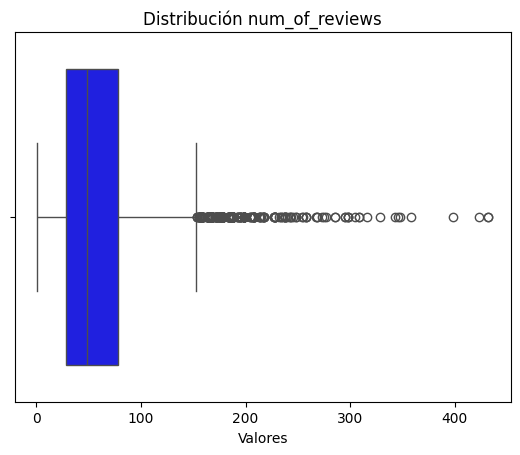

In [26]:
# Crear el gráfico de caja
sns.boxplot(x=df_subway_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

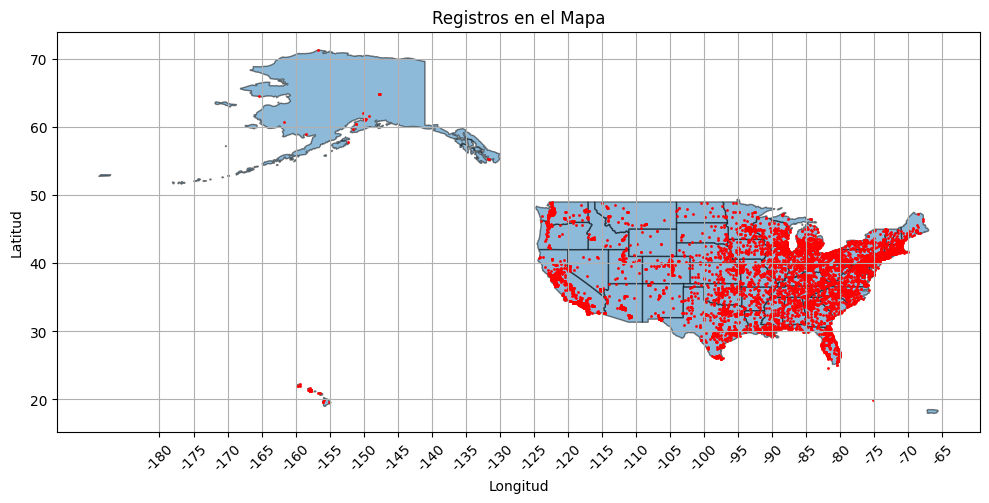

In [27]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_subway_restaurantes, geometry=gpd.points_from_xy(df_subway_restaurantes['longitude'], df_subway_restaurantes['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

In [28]:
df_subway_restaurantes.loc[(df_subway_restaurantes['latitude'] < 21) & (df_subway_restaurantes['longitude'] < -70) & (df_subway_restaurantes['longitude'] > -80)]

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
139328,Subway,"Subway, Sherman Ave",0x8ececf93aaa3553b:0x80d37fdf4ff72429,Casual counter-serve chain for build-your-own ...,19.916014,-75.139875,"[Sandwich shop, Restaurant]",4.0,55,$,"[[Monday, 6AM–10PM], [Tuesday, 6AM–10PM], [Wed...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 6AM,"[0x8ececfc0e847f4b1:0x3032c5de29d5e2b, 0x8ecec...",https://www.google.com/maps/place//data=!4m2!3...


Buscando en google la direccion me devuelve las correctas coordenadas del local

In [29]:
df_subway_restaurantes.loc[df_subway_restaurantes['gmap_id'] == "0x8ececf93aaa3553b:0x80d37fdf4ff72429", 'latitude'] = 43.127694
df_subway_restaurantes.loc[df_subway_restaurantes['gmap_id'] == "0x8ececf93aaa3553b:0x80d37fdf4ff72429", 'longitude'] = -89.363469

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [30]:
restaurantes = df_subway_restaurantes['gmap_id'].to_list()
df_subway_reviews = df_subway_reviews[df_subway_reviews['gmap_id'].isin(restaurantes)]
df_subway_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37883 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           37883 non-null  object 
 1   name_x            37883 non-null  object 
 2   time              37883 non-null  int64  
 3   rating            37883 non-null  int64  
 4   text              37883 non-null  object 
 5   pics              37883 non-null  object 
 6   resp              37883 non-null  object 
 7   gmap_id           37883 non-null  object 
 8   anio              37883 non-null  int64  
 9   estado            37883 non-null  object 
 10  name_y            37883 non-null  object 
 11  address           37883 non-null  object 
 12  description       37883 non-null  object 
 13  latitude          37883 non-null  float64
 14  longitude         37883 non-null  float64
 15  category          37883 non-null  object 
 16  avg_rating        37883 non-null  float64

### df_subway_reviews

In [31]:
df_subway_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37883 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           37883 non-null  object 
 1   name_x            37883 non-null  object 
 2   time              37883 non-null  int64  
 3   rating            37883 non-null  int64  
 4   text              37883 non-null  object 
 5   pics              37883 non-null  object 
 6   resp              37883 non-null  object 
 7   gmap_id           37883 non-null  object 
 8   anio              37883 non-null  int64  
 9   estado            37883 non-null  object 
 10  name_y            37883 non-null  object 
 11  address           37883 non-null  object 
 12  description       37883 non-null  object 
 13  latitude          37883 non-null  float64
 14  longitude         37883 non-null  float64
 15  category          37883 non-null  object 
 16  avg_rating        37883 non-null  float64

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [32]:
df_subway_reviews['avg_rating'].value_counts()

avg_rating
3.9    5152
4.0    5081
4.1    3889
3.8    3801
4.2    3760
3.7    2950
3.6    2818
4.3    2467
3.5    1764
3.4    1528
4.4    1243
3.3     975
3.2     641
3.1     365
3.0     299
2.8     181
2.7     174
4.6     167
4.5     163
2.9     158
2.6      93
2.5      80
2.3      46
2.4      37
4.7      22
1.8      10
4.9      10
2.0       9
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

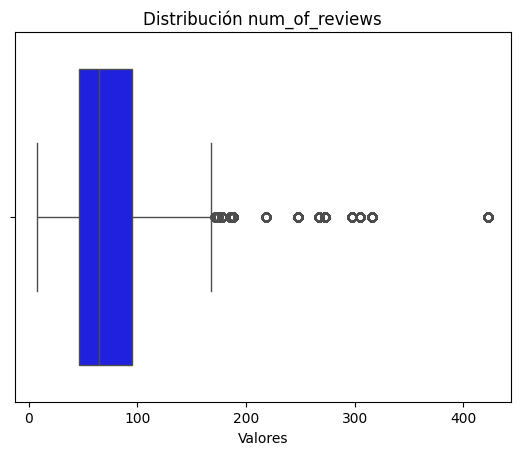

In [33]:
# Crear el gráfico de caja
sns.boxplot(x=df_subway_reviews['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

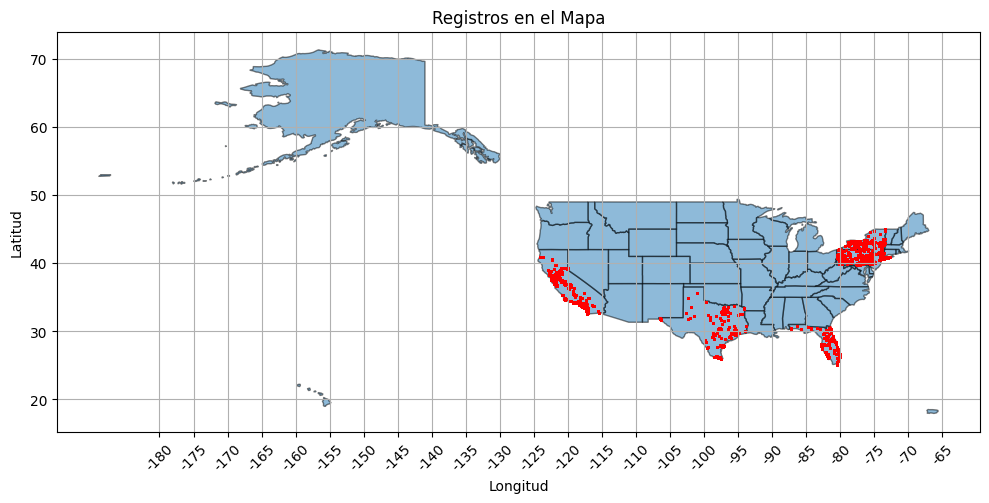

In [34]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_subway_reviews, geometry=gpd.points_from_xy(df_subway_reviews['longitude'], df_subway_reviews['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

## Dunkin Google

### df_dunkin_restaurantes

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [35]:
df_dunkin_restaurantes['avg_rating'].value_counts()

avg_rating
3.9    213
4.0    210
4.1    168
3.8    165
3.7    127
4.2    116
3.6    109
3.5     89
3.4     68
4.3     66
3.3     44
3.2     32
4.4     30
3.0     26
4.5     24
3.1     21
2.9     17
5.0     13
2.4     12
2.8      9
2.7      9
4.7      9
2.0      7
4.6      6
2.3      4
4.8      4
2.6      4
2.5      4
2.2      3
1.8      2
1.0      2
2.1      2
1.7      1
1.9      1
4.9      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

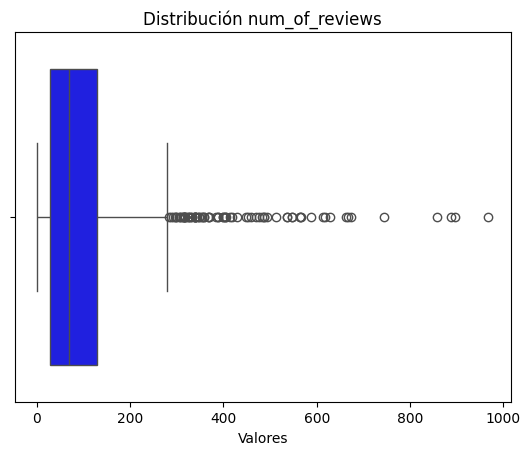

In [36]:
# Crear el gráfico de caja
sns.boxplot(x=df_dunkin_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

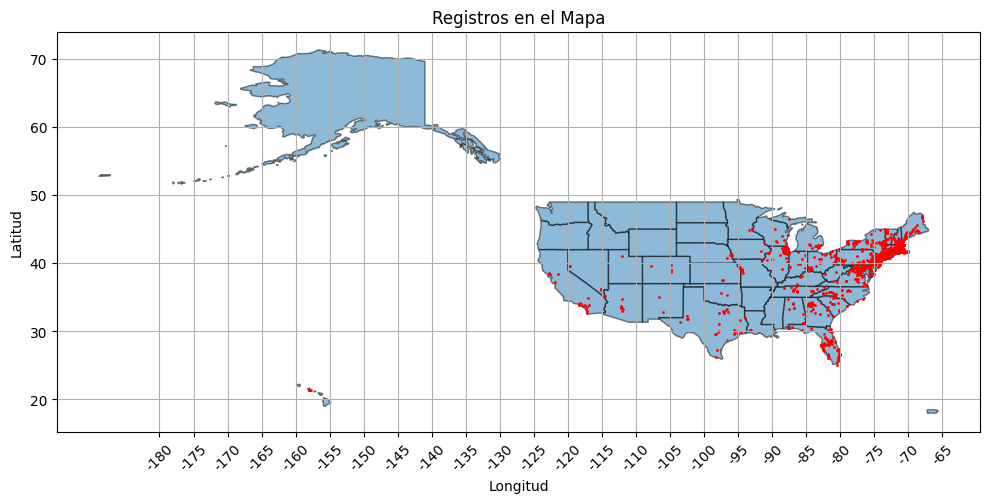

In [37]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_dunkin_restaurantes, geometry=gpd.points_from_xy(df_dunkin_restaurantes['longitude'], df_dunkin_restaurantes['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [38]:
restaurantes = df_dunkin_restaurantes['gmap_id'].to_list()
df_dunkin_reviews = df_dunkin_reviews[df_dunkin_reviews['gmap_id'].isin(restaurantes)]
df_dunkin_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21428 entries, 16186 to 2393451
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           21428 non-null  object 
 1   name_x            21428 non-null  object 
 2   time              21428 non-null  int64  
 3   rating            21428 non-null  int64  
 4   text              21428 non-null  object 
 5   pics              21428 non-null  object 
 6   resp              21428 non-null  object 
 7   gmap_id           21428 non-null  object 
 8   anio              21428 non-null  int64  
 9   estado            21428 non-null  object 
 10  name_y            21428 non-null  object 
 11  address           21428 non-null  object 
 12  description       21428 non-null  object 
 13  latitude          21428 non-null  float64
 14  longitude         21428 non-null  float64
 15  category          21428 non-null  object 
 16  avg_rating        21428 non-null  float

### df_dunkin_reviews

In [39]:
df_dunkin_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21428 entries, 16186 to 2393451
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           21428 non-null  object 
 1   name_x            21428 non-null  object 
 2   time              21428 non-null  int64  
 3   rating            21428 non-null  int64  
 4   text              21428 non-null  object 
 5   pics              21428 non-null  object 
 6   resp              21428 non-null  object 
 7   gmap_id           21428 non-null  object 
 8   anio              21428 non-null  int64  
 9   estado            21428 non-null  object 
 10  name_y            21428 non-null  object 
 11  address           21428 non-null  object 
 12  description       21428 non-null  object 
 13  latitude          21428 non-null  float64
 14  longitude         21428 non-null  float64
 15  category          21428 non-null  object 
 16  avg_rating        21428 non-null  float

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [40]:
df_dunkin_reviews['avg_rating'].value_counts()

avg_rating
4.0    5335
3.9    3738
4.1    2695
3.7    2259
3.8    1824
4.2    1741
3.5    1138
3.6    1105
4.3     463
3.4     452
3.3     267
3.2     148
4.4     135
4.5      76
3.0      20
2.7      18
2.0      11
3.1       2
2.8       1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

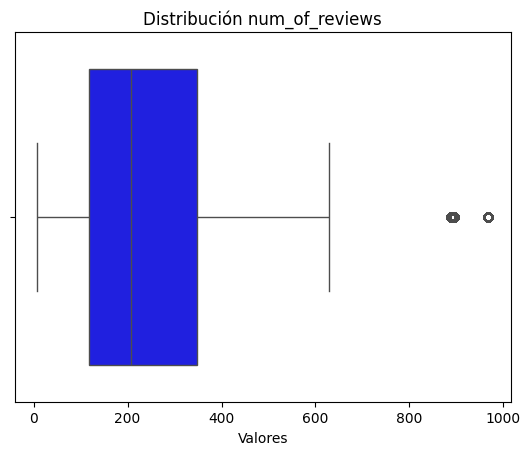

In [41]:
# Crear el gráfico de caja
sns.boxplot(x=df_dunkin_reviews['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

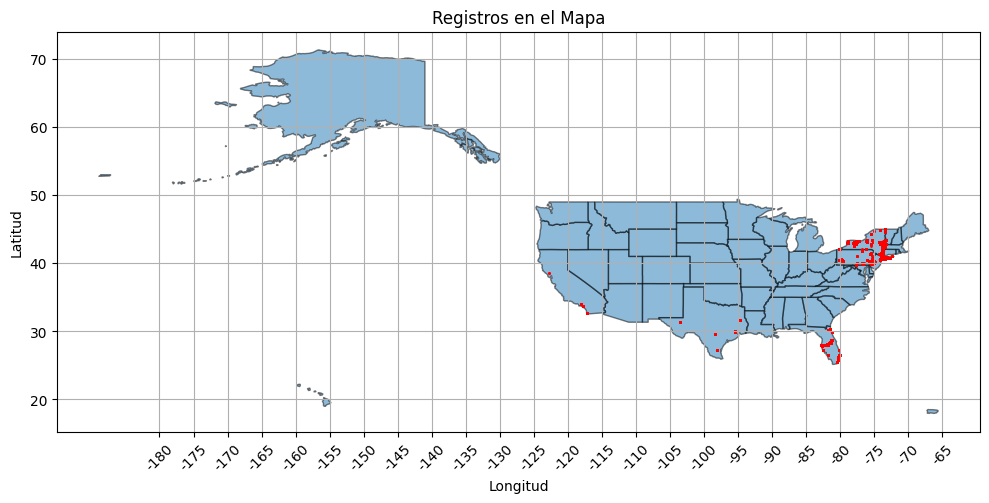

In [42]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_dunkin_reviews, geometry=gpd.points_from_xy(df_dunkin_reviews['longitude'], df_dunkin_reviews['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

## McDonald's Google

### df_mcdonalds_restaurantes

In [43]:
df_mcdonalds_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 208 to 211881
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              975 non-null    object 
 1   address           975 non-null    object 
 2   gmap_id           975 non-null    object 
 3   description       975 non-null    object 
 4   latitude          975 non-null    float64
 5   longitude         975 non-null    float64
 6   category          975 non-null    object 
 7   avg_rating        975 non-null    float64
 8   num_of_reviews    975 non-null    int64  
 9   price             975 non-null    object 
 10  hours             975 non-null    object 
 11  MISC              975 non-null    object 
 12  state             975 non-null    object 
 13  relative_results  975 non-null    object 
 14  url               975 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 121.9+ KB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [44]:
df_mcdonalds_restaurantes['avg_rating'].value_counts()

avg_rating
3.5    140
3.6    129
3.4    122
3.3    109
3.7     81
3.2     64
3.8     53
3.1     51
3.0     41
2.9     32
3.9     17
2.5     17
2.6     16
4.0     13
2.4     12
2.2     10
2.7     10
2.8     10
4.1      8
2.3      6
1.0      4
2.0      4
1.8      4
4.2      3
1.7      3
2.1      3
1.9      3
4.7      2
4.5      2
1.6      2
4.4      1
1.5      1
4.3      1
4.9      1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

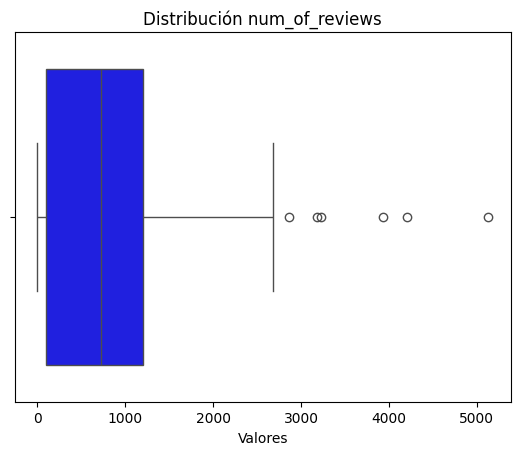

In [45]:
# Crear el gráfico de caja
sns.boxplot(x=df_mcdonalds_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

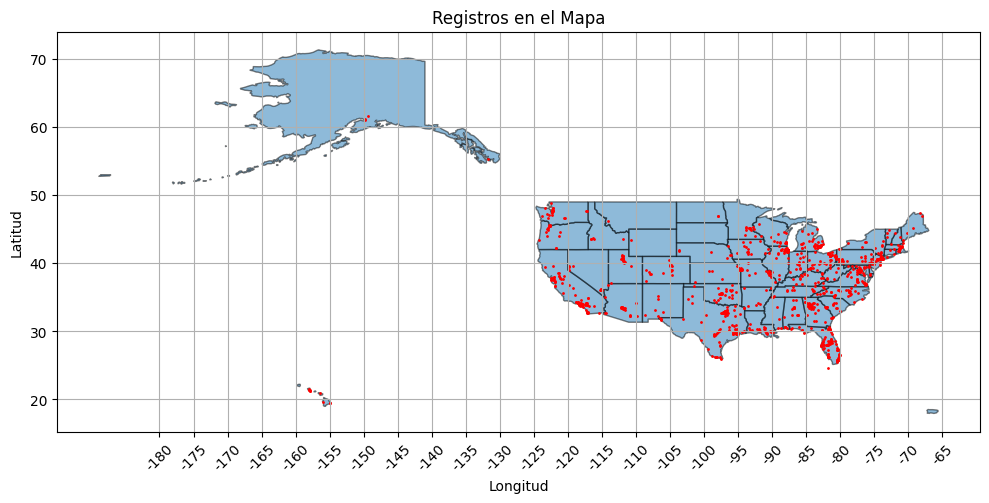

In [46]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_mcdonalds_restaurantes, geometry=gpd.points_from_xy(df_mcdonalds_restaurantes['longitude'], df_mcdonalds_restaurantes['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

El punto que parece que esta en el mar al sur de miami no es un Outlier, es un local que se encuentra en una isla llamada "Cayo Hueso"

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [47]:
restaurantes = df_mcdonalds_restaurantes['gmap_id'].to_list()
df_mcdonalds_reviews = df_mcdonalds_reviews[df_mcdonalds_reviews['gmap_id'].isin(restaurantes)]
df_mcdonalds_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114507 entries, 84 to 2370051
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           114507 non-null  object 
 1   name_x            114507 non-null  object 
 2   time              114507 non-null  int64  
 3   rating            114507 non-null  int64  
 4   text              114507 non-null  object 
 5   pics              114507 non-null  object 
 6   resp              114507 non-null  object 
 7   gmap_id           114507 non-null  object 
 8   anio              114507 non-null  int64  
 9   estado            114507 non-null  object 
 10  name_y            114507 non-null  object 
 11  address           114507 non-null  object 
 12  description       114507 non-null  object 
 13  latitude          114507 non-null  float64
 14  longitude         114507 non-null  float64
 15  category          114507 non-null  object 
 16  avg_rating        11450

### df_mcdonalds_reviews

In [48]:
df_mcdonalds_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114507 entries, 84 to 2370051
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           114507 non-null  object 
 1   name_x            114507 non-null  object 
 2   time              114507 non-null  int64  
 3   rating            114507 non-null  int64  
 4   text              114507 non-null  object 
 5   pics              114507 non-null  object 
 6   resp              114507 non-null  object 
 7   gmap_id           114507 non-null  object 
 8   anio              114507 non-null  int64  
 9   estado            114507 non-null  object 
 10  name_y            114507 non-null  object 
 11  address           114507 non-null  object 
 12  description       114507 non-null  object 
 13  latitude          114507 non-null  float64
 14  longitude         114507 non-null  float64
 15  category          114507 non-null  object 
 16  avg_rating        11450

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [49]:
df_mcdonalds_reviews['avg_rating'].value_counts()

avg_rating
3.5    21018
3.6    17192
3.7    16067
3.8    14191
3.4    13292
3.3    10091
3.9     5591
3.1     3904
3.0     3590
3.2     3467
4.0     3342
2.9     1072
2.8      790
4.1      740
2.2       53
2.5       50
2.4       23
2.6       20
1.8       14
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

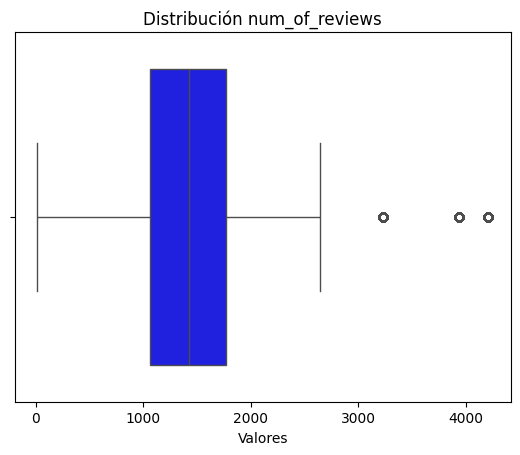

In [50]:
# Crear el gráfico de caja
sns.boxplot(x=df_mcdonalds_reviews['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

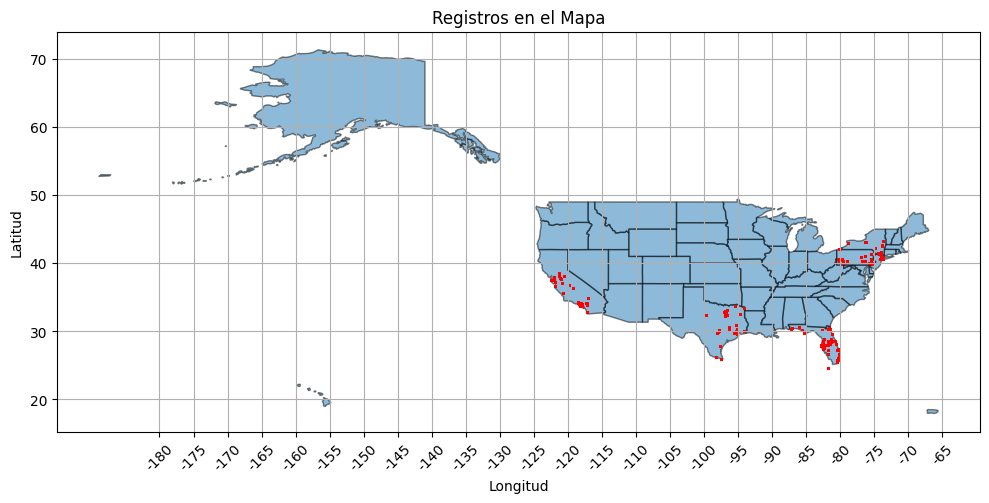

In [51]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_mcdonalds_reviews, geometry=gpd.points_from_xy(df_mcdonalds_reviews['longitude'], df_mcdonalds_reviews['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

## Burger king Google

### df_burger_king_restaurantes

In [52]:
df_burger_king_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, 192 to 211922
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              655 non-null    object 
 1   address           655 non-null    object 
 2   gmap_id           655 non-null    object 
 3   description       655 non-null    object 
 4   latitude          655 non-null    float64
 5   longitude         655 non-null    float64
 6   category          655 non-null    object 
 7   avg_rating        655 non-null    float64
 8   num_of_reviews    655 non-null    int64  
 9   price             655 non-null    object 
 10  hours             655 non-null    object 
 11  MISC              655 non-null    object 
 12  state             655 non-null    object 
 13  relative_results  655 non-null    object 
 14  url               655 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 81.9+ KB


#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [53]:
df_burger_king_restaurantes['avg_rating'].value_counts()

avg_rating
3.6    61
3.5    61
3.3    56
3.4    51
3.7    49
3.8    49
3.2    39
3.0    38
3.9    35
3.1    34
2.8    23
2.4    18
2.5    18
2.7    16
4.0    15
2.9    15
4.1    12
2.6    10
2.1     7
2.3     7
1.9     7
2.0     6
4.3     4
2.2     4
1.6     3
1.3     3
4.5     3
1.8     2
4.2     2
4.6     2
1.7     2
4.7     1
1.0     1
1.1     1
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

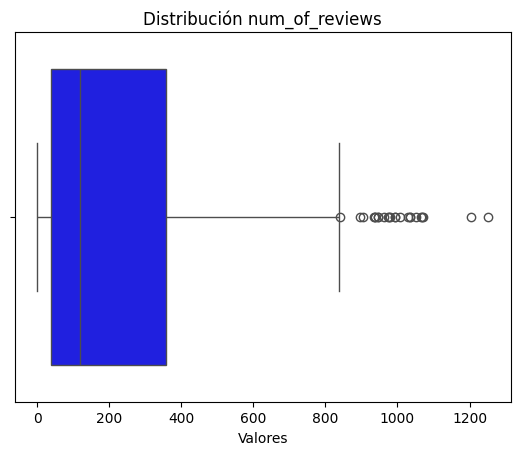

In [54]:
# Crear el gráfico de caja
sns.boxplot(x=df_burger_king_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

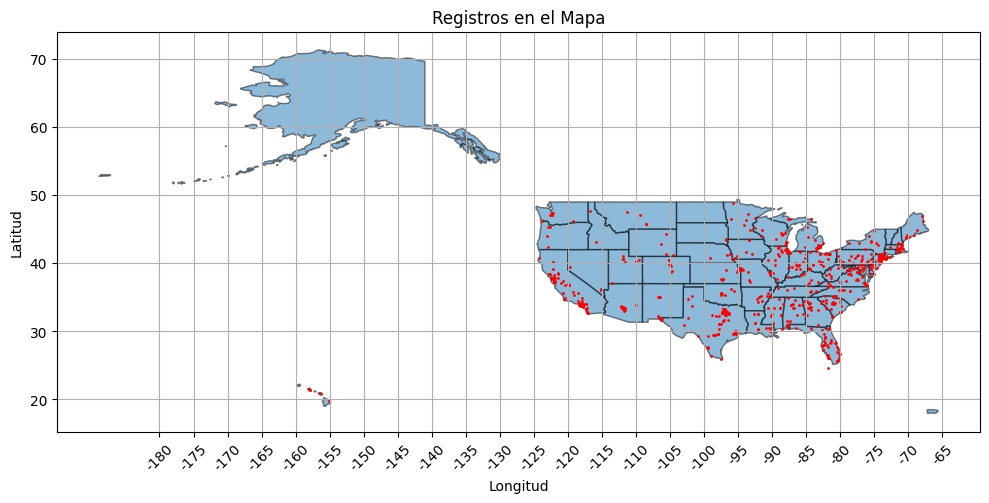

In [55]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_burger_king_restaurantes, geometry=gpd.points_from_xy(df_burger_king_restaurantes['longitude'], df_burger_king_restaurantes['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

El punto que parece que esta en el mar al sur de miami no es un Outlier, es un local que se encuentra en una isla llamada "Cayo Hueso"

### Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [56]:
restaurantes = df_burger_king_restaurantes['gmap_id'].to_list()
df_burger_king_reviews = df_burger_king_reviews[df_burger_king_reviews['gmap_id'].isin(restaurantes)]
df_burger_king_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18785 entries, 580 to 2357798
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           18785 non-null  object 
 1   name_x            18785 non-null  object 
 2   time              18785 non-null  int64  
 3   rating            18785 non-null  int64  
 4   text              18785 non-null  object 
 5   pics              18785 non-null  object 
 6   resp              18785 non-null  object 
 7   gmap_id           18785 non-null  object 
 8   anio              18785 non-null  int64  
 9   estado            18785 non-null  object 
 10  name_y            18785 non-null  object 
 11  address           18785 non-null  object 
 12  description       18785 non-null  object 
 13  latitude          18785 non-null  float64
 14  longitude         18785 non-null  float64
 15  category          18785 non-null  object 
 16  avg_rating        18785 non-null  float64

### df_burger_king_reviews

In [57]:
df_burger_king_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18785 entries, 580 to 2357798
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           18785 non-null  object 
 1   name_x            18785 non-null  object 
 2   time              18785 non-null  int64  
 3   rating            18785 non-null  int64  
 4   text              18785 non-null  object 
 5   pics              18785 non-null  object 
 6   resp              18785 non-null  object 
 7   gmap_id           18785 non-null  object 
 8   anio              18785 non-null  int64  
 9   estado            18785 non-null  object 
 10  name_y            18785 non-null  object 
 11  address           18785 non-null  object 
 12  description       18785 non-null  object 
 13  latitude          18785 non-null  float64
 14  longitude         18785 non-null  float64
 15  category          18785 non-null  object 
 16  avg_rating        18785 non-null  float64

#### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [58]:
df_burger_king_reviews['avg_rating'].value_counts()

avg_rating
3.7    3784
3.8    2663
3.3    1969
3.6    1836
3.5    1565
3.9    1553
4.0    1436
3.1    1101
3.4    1069
3.2     884
4.1     438
4.2     270
3.0      81
2.4      35
2.7      25
2.0      23
2.5      12
2.9      11
4.5      10
2.1       8
2.8       7
1.9       5
Name: count, dtype: int64

#### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

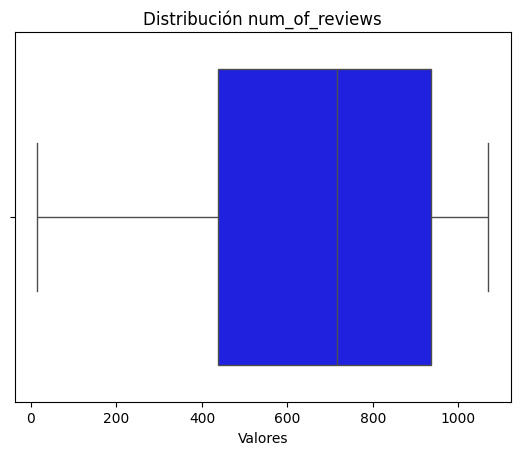

In [59]:
# Crear el gráfico de caja
sns.boxplot(x=df_burger_king_reviews['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

#### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

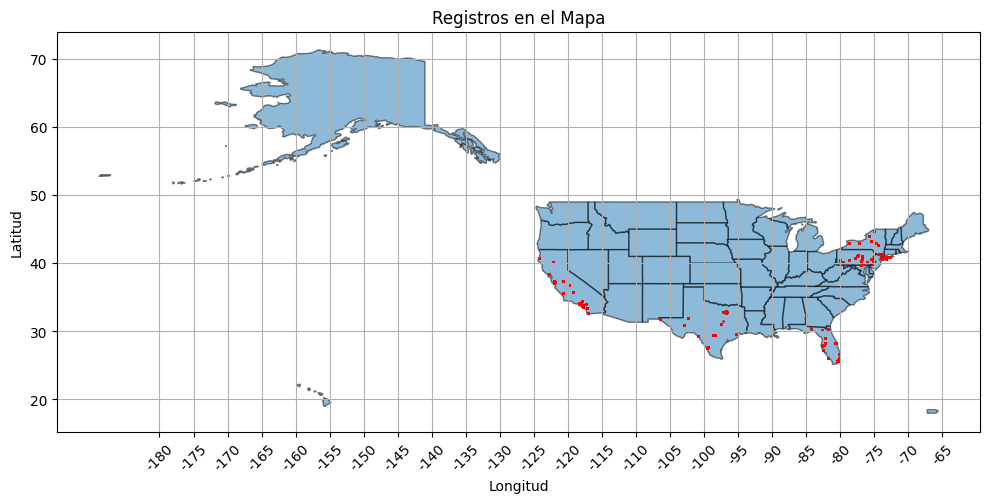

In [60]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_burger_king_reviews, geometry=gpd.points_from_xy(df_burger_king_reviews['longitude'], df_burger_king_reviews['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

# Google Maps Tipos de datos

## Subway Google

### df_subway_restaurantes

In [61]:
df_subway_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8550 entries, 173 to 212005
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8550 non-null   object 
 1   address           8550 non-null   object 
 2   gmap_id           8550 non-null   object 
 3   description       8550 non-null   object 
 4   latitude          8550 non-null   float64
 5   longitude         8550 non-null   float64
 6   category          8550 non-null   object 
 7   avg_rating        8550 non-null   float64
 8   num_of_reviews    8550 non-null   int64  
 9   price             8550 non-null   object 
 10  hours             8550 non-null   object 
 11  MISC              8550 non-null   object 
 12  state             8550 non-null   object 
 13  relative_results  8550 non-null   object 
 14  url               8550 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.0+ MB


Cambiamos el tipo de datos de las columnas `avg_rating`, `num_of_reviews` y `price` para reducir el uso de memoria a cambio de precisiòn innecesaria en los datos

In [62]:
df_subway_restaurantes_copy = df_subway_restaurantes.copy()
df_subway_restaurantes_copy['avg_rating'] = df_subway_restaurantes_copy['avg_rating'].astype('float32')

# Convertir 'num_of_reviews' a int32
df_subway_restaurantes_copy['num_of_reviews'] = df_subway_restaurantes_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_subway_restaurantes_copy['price'] = df_subway_restaurantes_copy['price'].astype('category')

# Asignar la copia modificada al DataFrame original
df_subway_restaurantes = df_subway_restaurantes_copy

### df_subway_reviews

In [63]:
print(df_subway_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 37883 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           37883 non-null  object 
 1   name_x            37883 non-null  object 
 2   time              37883 non-null  int64  
 3   rating            37883 non-null  int64  
 4   text              37883 non-null  object 
 5   pics              37883 non-null  object 
 6   resp              37883 non-null  object 
 7   gmap_id           37883 non-null  object 
 8   anio              37883 non-null  int64  
 9   estado            37883 non-null  object 
 10  name_y            37883 non-null  object 
 11  address           37883 non-null  object 
 12  description       37883 non-null  object 
 13  latitude          37883 non-null  float64
 14  longitude         37883 non-null  float64
 15  category          37883 non-null  object 
 16  avg_rating        37883 non-null  float64

Cambiamos el tipo de datos de las columnas para reducir el uso de memoria.

In [64]:
# Convertir 'rating' a int8
df_subway_reviews_copy = df_subway_reviews.copy()
df_subway_reviews_copy['rating'] = df_subway_reviews_copy['rating'].astype('int8')

# Convertir 'num_of_reviews' a int32
df_subway_reviews_copy['num_of_reviews'] = df_subway_reviews_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_subway_reviews_copy['price'] = df_subway_reviews_copy['price'].astype('category')

# Convertir 'anio' a category
df_subway_reviews_copy['anio'] = df_subway_reviews_copy['anio'].astype('category')

# Convertir 'estado' a category
df_subway_reviews_copy['estado'] = df_subway_reviews_copy['estado'].astype('category')

# Convertir 'avg_rating' a float32
df_subway_reviews_copy['avg_rating'] = df_subway_reviews_copy['avg_rating'].astype('float32')

# Convertir 'state_ab' a category
df_subway_reviews_copy['state_ab'] = df_subway_reviews_copy['state_ab'].astype('category')

# Convertir 'us_state' a category
df_subway_reviews_copy['us_state'] = df_subway_reviews_copy['us_state'].astype('category')

# Asignar la copia modificada al DataFrame original
df_subway_reviews = df_subway_reviews_copy

## Dunkin Google

### df_dunkin_restaurantes

In [65]:
df_dunkin_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, 30 to 212011
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1618 non-null   object 
 1   address           1618 non-null   object 
 2   gmap_id           1618 non-null   object 
 3   description       1618 non-null   object 
 4   latitude          1618 non-null   float64
 5   longitude         1618 non-null   float64
 6   category          1618 non-null   object 
 7   avg_rating        1618 non-null   float64
 8   num_of_reviews    1618 non-null   int64  
 9   price             1618 non-null   object 
 10  hours             1618 non-null   object 
 11  MISC              1618 non-null   object 
 12  state             1618 non-null   object 
 13  relative_results  1618 non-null   object 
 14  url               1618 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 202.2+ KB


Cambiamos el tipo de datos de las columnas `avg_rating`, `num_of_reviews` y `price` para reducir el uso de memoria a cambio de precisiòn innecesaria en los datos

In [66]:
df_dunkin_restaurantes_copy = df_dunkin_restaurantes.copy()
df_dunkin_restaurantes_copy['avg_rating'] = df_dunkin_restaurantes_copy['avg_rating'].astype('float32')

# Convertir 'num_of_reviews' a int32
df_dunkin_restaurantes_copy['num_of_reviews'] = df_dunkin_restaurantes_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_dunkin_restaurantes_copy['price'] = df_dunkin_restaurantes_copy['price'].astype('category')

# Asignar la copia modificada al DataFrame original
df_dunkin_restaurantes = df_dunkin_restaurantes_copy

### df_dunkin_reviews

In [67]:
print(df_dunkin_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21428 entries, 16186 to 2393451
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           21428 non-null  object 
 1   name_x            21428 non-null  object 
 2   time              21428 non-null  int64  
 3   rating            21428 non-null  int64  
 4   text              21428 non-null  object 
 5   pics              21428 non-null  object 
 6   resp              21428 non-null  object 
 7   gmap_id           21428 non-null  object 
 8   anio              21428 non-null  int64  
 9   estado            21428 non-null  object 
 10  name_y            21428 non-null  object 
 11  address           21428 non-null  object 
 12  description       21428 non-null  object 
 13  latitude          21428 non-null  float64
 14  longitude         21428 non-null  float64
 15  category          21428 non-null  object 
 16  avg_rating        21428 non-null  float

Cambiamos el tipo de datos de las columnas para reducir el uso de memoria.

In [68]:
# Convertir 'rating' a int8
df_dunkin_reviews_copy = df_dunkin_reviews.copy()
df_dunkin_reviews_copy['rating'] = df_dunkin_reviews_copy['rating'].astype('int8')

# Convertir 'num_of_reviews' a int32
df_dunkin_reviews_copy['num_of_reviews'] = df_dunkin_reviews_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_dunkin_reviews_copy['price'] = df_dunkin_reviews_copy['price'].astype('category')

# Convertir 'anio' a category
df_dunkin_reviews_copy['anio'] = df_dunkin_reviews_copy['anio'].astype('category')

# Convertir 'estado' a category
df_dunkin_reviews_copy['estado'] = df_dunkin_reviews_copy['estado'].astype('category')

# Convertir 'avg_rating' a float32
df_dunkin_reviews_copy['avg_rating'] = df_dunkin_reviews_copy['avg_rating'].astype('float32')

# Convertir 'state_ab' a category
df_dunkin_reviews_copy['state_ab'] = df_dunkin_reviews_copy['state_ab'].astype('category')

# Convertir 'us_state' a category
df_dunkin_reviews_copy['us_state'] = df_dunkin_reviews_copy['us_state'].astype('category')

# Asignar la copia modificada al DataFrame original
df_dunkin_reviews = df_dunkin_reviews_copy

## McDonald's Google

### df_mcdonalds_restaurantes

In [69]:
df_mcdonalds_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 208 to 211881
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              975 non-null    object 
 1   address           975 non-null    object 
 2   gmap_id           975 non-null    object 
 3   description       975 non-null    object 
 4   latitude          975 non-null    float64
 5   longitude         975 non-null    float64
 6   category          975 non-null    object 
 7   avg_rating        975 non-null    float64
 8   num_of_reviews    975 non-null    int64  
 9   price             975 non-null    object 
 10  hours             975 non-null    object 
 11  MISC              975 non-null    object 
 12  state             975 non-null    object 
 13  relative_results  975 non-null    object 
 14  url               975 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 121.9+ KB


Cambiamos el tipo de datos de las columnas `avg_rating`, `num_of_reviews` y `price` para reducir el uso de memoria a cambio de precisiòn innecesaria en los datos

In [70]:
df_mcdonalds_restaurantes_copy = df_mcdonalds_restaurantes.copy()
df_mcdonalds_restaurantes_copy['avg_rating'] = df_mcdonalds_restaurantes_copy['avg_rating'].astype('float32')

# Convertir 'num_of_reviews' a int32
df_mcdonalds_restaurantes_copy['num_of_reviews'] = df_mcdonalds_restaurantes_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_mcdonalds_restaurantes_copy['price'] = df_mcdonalds_restaurantes_copy['price'].astype('category')

# Asignar la copia modificada al DataFrame original
df_mcdonalds_restaurantes = df_mcdonalds_restaurantes_copy

### df_mcdonalds_reviews

In [71]:
print(df_mcdonalds_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 114507 entries, 84 to 2370051
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           114507 non-null  object 
 1   name_x            114507 non-null  object 
 2   time              114507 non-null  int64  
 3   rating            114507 non-null  int64  
 4   text              114507 non-null  object 
 5   pics              114507 non-null  object 
 6   resp              114507 non-null  object 
 7   gmap_id           114507 non-null  object 
 8   anio              114507 non-null  int64  
 9   estado            114507 non-null  object 
 10  name_y            114507 non-null  object 
 11  address           114507 non-null  object 
 12  description       114507 non-null  object 
 13  latitude          114507 non-null  float64
 14  longitude         114507 non-null  float64
 15  category          114507 non-null  object 
 16  avg_rating        11450

Cambiamos el tipo de datos de las columnas para reducir el uso de memoria.

In [72]:
# Convertir 'rating' a int8
df_mcdonalds_reviews_copy = df_mcdonalds_reviews.copy()
df_mcdonalds_reviews_copy['rating'] = df_mcdonalds_reviews_copy['rating'].astype('int8')

# Convertir 'num_of_reviews' a int32
df_mcdonalds_reviews_copy['num_of_reviews'] = df_mcdonalds_reviews_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_mcdonalds_reviews_copy['price'] = df_mcdonalds_reviews_copy['price'].astype('category')

# Convertir 'anio' a category
df_mcdonalds_reviews_copy['anio'] = df_mcdonalds_reviews_copy['anio'].astype('category')

# Convertir 'estado' a category
df_mcdonalds_reviews_copy['estado'] = df_mcdonalds_reviews_copy['estado'].astype('category')

# Convertir 'avg_rating' a float32
df_mcdonalds_reviews_copy['avg_rating'] = df_mcdonalds_reviews_copy['avg_rating'].astype('float32')

# Convertir 'state_ab' a category
df_mcdonalds_reviews_copy['state_ab'] = df_mcdonalds_reviews_copy['state_ab'].astype('category')

# Convertir 'us_state' a category
df_mcdonalds_reviews_copy['us_state'] = df_mcdonalds_reviews_copy['us_state'].astype('category')

# Asignar la copia modificada al DataFrame original
df_mcdonalds_reviews = df_mcdonalds_reviews_copy

## Burger king Google

### df_burger_king_restaurantes

In [73]:
df_burger_king_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, 192 to 211922
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              655 non-null    object 
 1   address           655 non-null    object 
 2   gmap_id           655 non-null    object 
 3   description       655 non-null    object 
 4   latitude          655 non-null    float64
 5   longitude         655 non-null    float64
 6   category          655 non-null    object 
 7   avg_rating        655 non-null    float64
 8   num_of_reviews    655 non-null    int64  
 9   price             655 non-null    object 
 10  hours             655 non-null    object 
 11  MISC              655 non-null    object 
 12  state             655 non-null    object 
 13  relative_results  655 non-null    object 
 14  url               655 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 81.9+ KB


Cambiamos el tipo de datos de las columnas `avg_rating`, `num_of_reviews` y `price` para reducir el uso de memoria a cambio de precisiòn innecesaria en los datos

In [74]:
df_burger_king_restaurantes_copy = df_burger_king_restaurantes.copy()
df_burger_king_restaurantes_copy['avg_rating'] = df_burger_king_restaurantes_copy['avg_rating'].astype('float32')

# Convertir 'num_of_reviews' a int32
df_burger_king_restaurantes_copy['num_of_reviews'] = df_burger_king_restaurantes_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_burger_king_restaurantes_copy['price'] = df_burger_king_restaurantes_copy['price'].astype('category')

# Asignar la copia modificada al DataFrame original
df_burger_king_restaurantes = df_burger_king_restaurantes_copy

### df_burger_king_reviews

In [75]:
print(df_burger_king_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18785 entries, 580 to 2357798
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           18785 non-null  object 
 1   name_x            18785 non-null  object 
 2   time              18785 non-null  int64  
 3   rating            18785 non-null  int64  
 4   text              18785 non-null  object 
 5   pics              18785 non-null  object 
 6   resp              18785 non-null  object 
 7   gmap_id           18785 non-null  object 
 8   anio              18785 non-null  int64  
 9   estado            18785 non-null  object 
 10  name_y            18785 non-null  object 
 11  address           18785 non-null  object 
 12  description       18785 non-null  object 
 13  latitude          18785 non-null  float64
 14  longitude         18785 non-null  float64
 15  category          18785 non-null  object 
 16  avg_rating        18785 non-null  float64

Cambiamos el tipo de datos de las columnas para reducir el uso de memoria.

In [76]:
# Convertir 'rating' a int8
df_burger_king_reviews_copy = df_burger_king_reviews.copy()
df_burger_king_reviews_copy['rating'] = df_burger_king_reviews_copy['rating'].astype('int8')

# Convertir 'num_of_reviews' a int32
df_burger_king_reviews_copy['num_of_reviews'] = df_burger_king_reviews_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_burger_king_reviews_copy['price'] = df_burger_king_reviews_copy['price'].astype('category')

# Convertir 'anio' a category
df_burger_king_reviews_copy['anio'] = df_burger_king_reviews_copy['anio'].astype('category')

# Convertir 'estado' a category
df_burger_king_reviews_copy['estado'] = df_burger_king_reviews_copy['estado'].astype('category')

# Convertir 'avg_rating' a float32
df_burger_king_reviews_copy['avg_rating'] = df_burger_king_reviews_copy['avg_rating'].astype('float32')

# Convertir 'state_ab' a category
df_burger_king_reviews_copy['state_ab'] = df_burger_king_reviews_copy['state_ab'].astype('category')

# Convertir 'us_state' a category
df_burger_king_reviews_copy['us_state'] = df_burger_king_reviews_copy['us_state'].astype('category')

# Asignar la copia modificada al DataFrame original
df_burger_king_reviews = df_burger_king_reviews_copy

# Distribuciòn de los datos

## df_yelp_restaurantes

### `state`

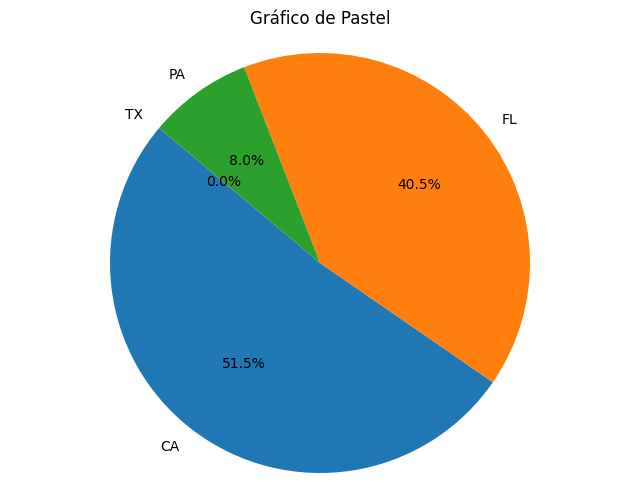

In [77]:
plt.figure(figsize=(8, 6))
plt.pie(df_yelp_restaurantes['state'].value_counts(), labels=df_yelp_restaurantes['state'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Gráfico de Pastel')
plt.axis('equal')  # Para asegurar que el pastel se vea como un círculo
plt.show()

### `stars`

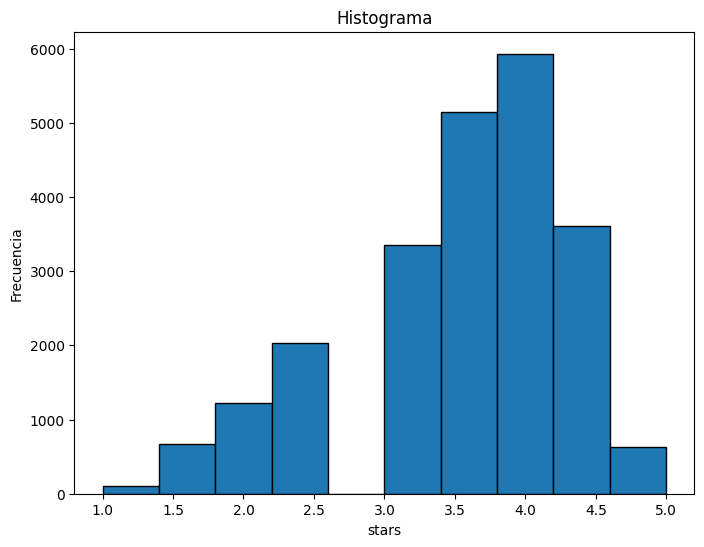

In [78]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_yelp_restaurantes['stars'], edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('stars')
plt.ylabel('Frecuencia')
plt.show()

### `review_count`

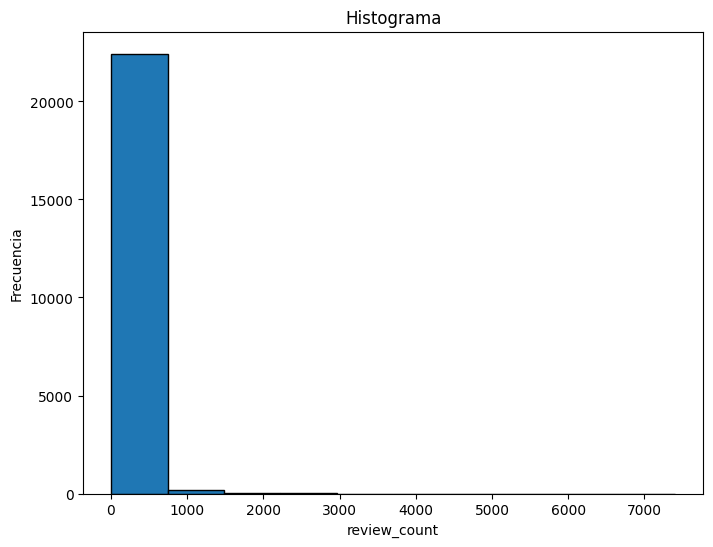

In [79]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_yelp_restaurantes['review_count'],edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('review_count')
plt.ylabel('Frecuencia')
plt.show()

### `is_open`

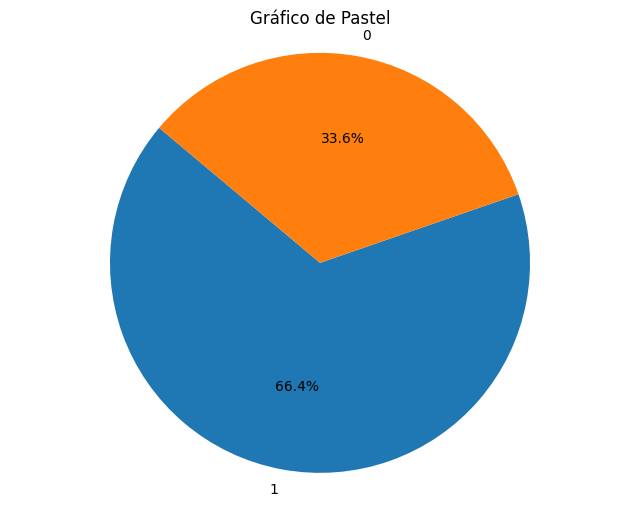

In [80]:
plt.figure(figsize=(8, 6))
plt.pie(df_yelp_restaurantes['is_open'].value_counts(), labels=df_yelp_restaurantes['is_open'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Gráfico de Pastel')
plt.axis('equal')  # Para asegurar que el pastel se vea como un círculo
plt.show()

## df_yelp_checkin

In [81]:
df_yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   3330 non-null   object 
 1   name          3330 non-null   object 
 2   address       3330 non-null   object 
 3   city          3330 non-null   object 
 4   state         3330 non-null   object 
 5   postal_code   3330 non-null   object 
 6   latitude      3330 non-null   float64
 7   longitude     3330 non-null   float64
 8   stars         3330 non-null   float64
 9   review_count  3330 non-null   int64  
 10  is_open       3330 non-null   int64  
 11  attributes    3296 non-null   object 
 12  categories    3330 non-null   object 
 13  hours         3082 non-null   object 
 14  date          3330 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 390.4+ KB


### `state`

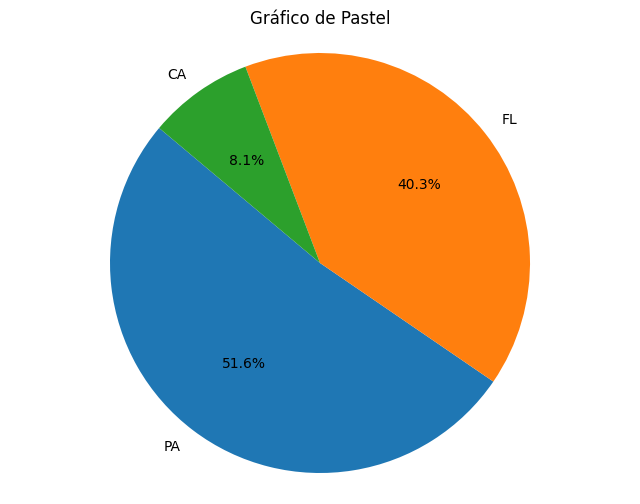

In [82]:
plt.figure(figsize=(8, 6))
plt.pie(df_yelp_checkin['state'].value_counts(), labels=df_yelp_checkin['state'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Gráfico de Pastel')
plt.axis('equal')  # Para asegurar que el pastel se vea como un círculo
plt.show()

### `stars`

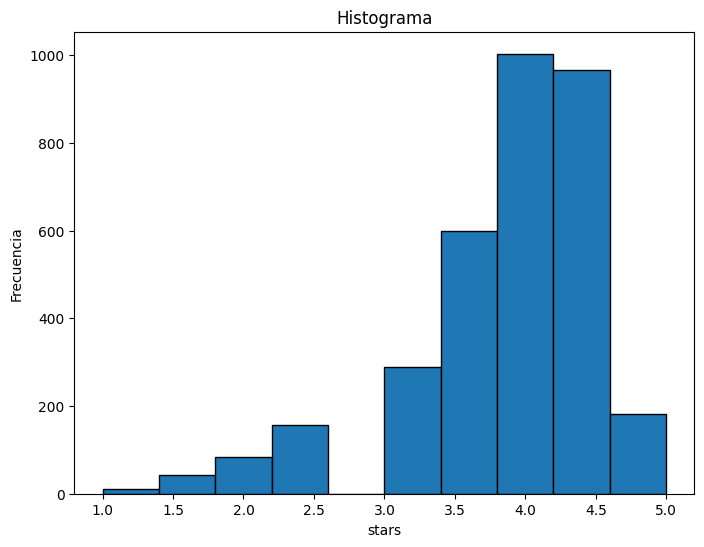

In [83]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_yelp_checkin['stars'], edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('stars')
plt.ylabel('Frecuencia')
plt.show()

### `review_count`

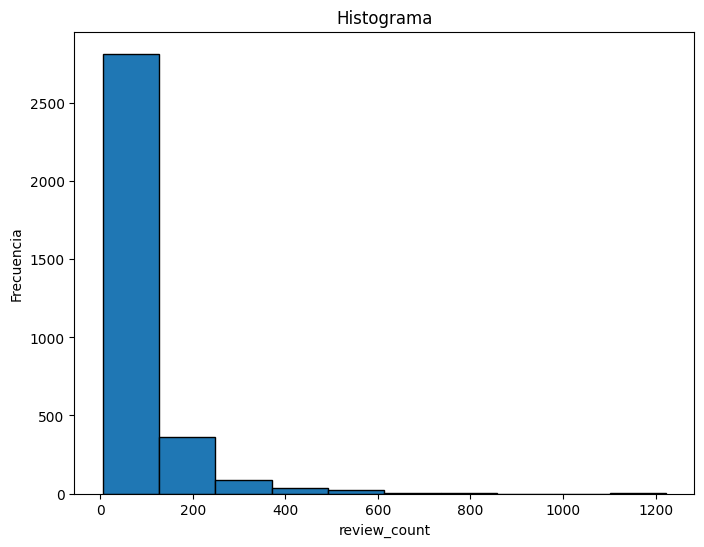

In [84]:
# Graficar el histograma
plt.figure(figsize=(8, 6))
plt.hist(df_yelp_checkin['review_count'],edgecolor='black')  # El parámetro bins determina la cantidad de barras
plt.title('Histograma')
plt.xlabel('review_count')
plt.ylabel('Frecuencia')
plt.show()

### `is_open`

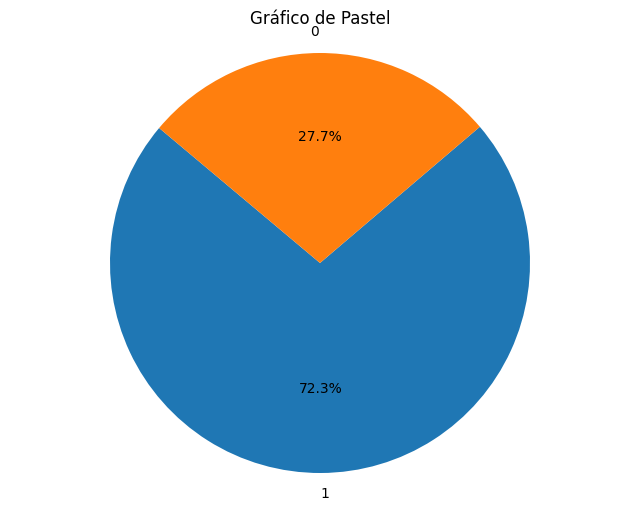

In [85]:
plt.figure(figsize=(8, 6))
plt.pie(df_yelp_checkin['is_open'].value_counts(), labels=df_yelp_checkin['is_open'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Gráfico de Pastel')
plt.axis('equal')  # Para asegurar que el pastel se vea como un círculo
plt.show()

## Unificaremos los datos de restaurantes de Yelp y Maps para nuestro cliente y la competencia

Esto lo haremos primero sustrayendo la informacion del cliente y la compentecia del dataframe de yelp

Se transformarán estos dataframes para darles una forma igual a los dataframes de Maps, luego se unirán asi se unifica la informacion

como siempre, empezaremos por el cliente

In [86]:
subway_rest_yelp = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains(r'Subway', case= False)]
dunkin_rest_yelp = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains(r'dunkin', case= False)]
MC_rest_yelp = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains(r'donald', case= False)]
BK_rest_yelp = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains(r'burger king', case= False)]

Se Hacen las transformaciones

In [87]:
subway_rest_yelp['address'] = subway_rest_yelp['address'] + ', ' + subway_rest_yelp['city'] + ', ' + subway_rest_yelp['postal_code'] + ', ' + subway_rest_yelp['state']
subway_rest_yelp = subway_rest_yelp.rename(columns={'business_id': 'gmap_id'})
subway_rest_yelp = subway_rest_yelp.rename(columns={'stars': 'avg_rating', 'review_count': 'num_of_reviews'})
subway_rest_yelp['is_open'] = subway_rest_yelp['is_open'].map({0: 'temporarily closed', 1: 'open'})
subway_rest_yelp = subway_rest_yelp.rename(columns={'categories': 'MISC'})

col = ['attributes','city','state','postal_code']
subway_rest_yelp = subway_rest_yelp.drop(columns= col)
subway_rest_yelp.head(1)

C:\Users\OS\AppData\Local\Temp\ipykernel_8944\2301713968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_rest_yelp['address'] = subway_rest_yelp['address'] + ', ' + subway_rest_yelp['city'] + ', ' + subway_rest_yelp['postal_code'] + ', ' + subway_rest_yelp['state']


,gmap_id,name,address,latitude,longitude,avg_rating,num_of_reviews,is_open,MISC,hours
964,vuL3QCjFZ7lU5LMdUAmZ9Q,Subway,"383 W Lancaster Ave, Wayne, 19087, FL",40.044263,-75.399354,1.5,5,temporarily closed,"Sandwiches, Fast Food, Restaurants",None


In [88]:
new_columns = ['description', 'category', 'price', 'relative_results', 'url']
default_values = ['Not Applicable'] * len(new_columns)

# Agregar columnas faltantes
for column, value in zip(new_columns, default_values):
    subway_rest_yelp[column] = value

# Reordenar columnas según el otro DataFrame
desired_columns = ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating',
                   'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
subway_rest_yelp = subway_rest_yelp.reindex(columns=desired_columns)
subway_restaurante_final = pd.concat([subway_rest_yelp, df_subway_restaurantes], ignore_index=True)

se unifican los dataframes

Proseguimos con Dunkin

In [89]:
dunkin_rest_yelp['address'] = dunkin_rest_yelp['address'] + ', ' + dunkin_rest_yelp['city'] + ', ' + dunkin_rest_yelp['postal_code'] + ', ' + dunkin_rest_yelp['state']
dunkin_rest_yelp = dunkin_rest_yelp.rename(columns={'business_id': 'gmap_id'})
dunkin_rest_yelp = dunkin_rest_yelp.rename(columns={'stars': 'avg_rating', 'review_count': 'num_of_reviews'})
dunkin_rest_yelp['is_open'] = dunkin_rest_yelp['is_open'].map({0: 'temporarily closed', 1: 'open'})
dunkin_rest_yelp = dunkin_rest_yelp.rename(columns={'categories': 'MISC'})

col = ['attributes','city','state','postal_code']
dunkin_rest_yelp = dunkin_rest_yelp.drop(columns= col)
dunkin_rest_yelp.head(1)

C:\Users\OS\AppData\Local\Temp\ipykernel_8944\2513102630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dunkin_rest_yelp['address'] = dunkin_rest_yelp['address'] + ', ' + dunkin_rest_yelp['city'] + ', ' + dunkin_rest_yelp['postal_code'] + ', ' + dunkin_rest_yelp['state']


,gmap_id,name,address,latitude,longitude,avg_rating,num_of_reviews,is_open,MISC,hours
6337,MUQDp-1rzSN3lCjUycNLug,Dunkin',"3313 Wharton St, Philadelphia, 19146, PA",39.938515,-75.198197,2.0,16,open,"Donuts, Food, Coffee & Tea, Restaurants","{'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Sa..."


In [90]:
new_columns = ['description', 'category', 'price', 'relative_results', 'url']
default_values = ['Not Applicable'] * len(new_columns)

# Agregar columnas faltantes
for column, value in zip(new_columns, default_values):
    dunkin_rest_yelp[column] = value

# Reordenar columnas según el otro DataFrame
desired_columns = ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating',
                   'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
dunkin_rest_yelp = dunkin_rest_yelp.reindex(columns=desired_columns)
dunkin_rest_final = pd.concat([dunkin_rest_yelp, df_dunkin_restaurantes], ignore_index=True)

Proseguimos con Mc Donalds

In [91]:
MC_rest_yelp['address'] = MC_rest_yelp['address'] + ', ' + MC_rest_yelp['city'] + ', ' + MC_rest_yelp['postal_code'] + ', ' + MC_rest_yelp['state']
MC_rest_yelp = MC_rest_yelp.rename(columns={'business_id': 'gmap_id'})
MC_rest_yelp = MC_rest_yelp.rename(columns={'stars': 'avg_rating', 'review_count': 'num_of_reviews'})
MC_rest_yelp['is_open'] = MC_rest_yelp['is_open'].map({0: 'temporarily closed', 1: 'open'})
MC_rest_yelp = MC_rest_yelp.rename(columns={'categories': 'MISC'})

col = ['attributes','city','state','postal_code']
MC_rest_yelp = MC_rest_yelp.drop(columns= col)
MC_rest_yelp.head(1)

C:\Users\OS\AppData\Local\Temp\ipykernel_8944\3519029864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC_rest_yelp['address'] = MC_rest_yelp['address'] + ', ' + MC_rest_yelp['city'] + ', ' + MC_rest_yelp['postal_code'] + ', ' + MC_rest_yelp['state']


,gmap_id,name,address,latitude,longitude,avg_rating,num_of_reviews,is_open,MISC,hours
193,yM8LlTInbQH4FwWC97lz6w,McDonald's,"1919 S Jefferson, St. Louis, 63104, PA",38.612495,-90.221942,1.5,100,open,"Fast Food, Restaurants, Food, Burgers, Coffee ...","{'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Sa..."


In [92]:
new_columns = ['description', 'category', 'price', 'relative_results', 'url']
default_values = ['Not Applicable'] * len(new_columns)

# Agregar columnas faltantes
for column, value in zip(new_columns, default_values):
    MC_rest_yelp[column] = value

# Reordenar columnas según el otro DataFrame
desired_columns = ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating',
                   'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
MC_rest_yelp = MC_rest_yelp.reindex(columns=desired_columns)
MC_rest_final = pd.concat([MC_rest_yelp, df_mcdonalds_restaurantes], ignore_index=True)

Y terminaremos con Burger King

In [93]:
BK_rest_yelp['address'] = BK_rest_yelp['address'] + ', ' + BK_rest_yelp['city'] + ', ' + BK_rest_yelp['postal_code'] + ', ' + BK_rest_yelp['state']
BK_rest_yelp = BK_rest_yelp.rename(columns={'business_id': 'gmap_id'})
BK_rest_yelp = BK_rest_yelp.rename(columns={'stars': 'avg_rating', 'review_count': 'num_of_reviews'})
BK_rest_yelp['is_open'] = BK_rest_yelp['is_open'].map({0: 'temporarily closed', 1: 'open'})
BK_rest_yelp = BK_rest_yelp.rename(columns={'categories': 'MISC'})

col = ['attributes','city','state','postal_code']
BK_rest_yelp = BK_rest_yelp.drop(columns= col)
BK_rest_yelp.head(1)

C:\Users\OS\AppData\Local\Temp\ipykernel_8944\4224193788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BK_rest_yelp['address'] = BK_rest_yelp['address'] + ', ' + BK_rest_yelp['city'] + ', ' + BK_rest_yelp['postal_code'] + ', ' + BK_rest_yelp['state']


,gmap_id,name,address,latitude,longitude,avg_rating,num_of_reviews,is_open,MISC,hours
1329,diqXZ9CBFlIHW7i9UHefhw,Burger King,"363 Harding Pl, Nashville, 37211, PA",36.084277,-86.70424,1.5,9,open,"Restaurants, Burgers, Fast Food","{'Friday': '6:0-20:0', 'Monday': '6:0-23:0', '..."


In [94]:
new_columns = ['description', 'category', 'price', 'relative_results', 'url']
default_values = ['Not Applicable'] * len(new_columns)

# Agregar columnas faltantes
for column, value in zip(new_columns, default_values):
    BK_rest_yelp[column] = value

# Reordenar columnas según el otro DataFrame
desired_columns = ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating',
                   'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
BK_rest_yelp = BK_rest_yelp.reindex(columns=desired_columns)
BK_rest_final = pd.concat([BK_rest_yelp, df_burger_king_restaurantes], ignore_index=True)

Ahora seguiremos un proces similar para obtener las 
### reviews

usaremos los business_ID de df_yelp_restaurantes para cruzarlo con los business_id de df_yelp_reviews y asi obtener las reviews de nuestro cliente y la competencia

In [95]:
subway_business_ids = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains('Subway',case= False), 'business_id'].tolist()
reviews_yelp_subway = df_yelp_reviews[df_yelp_reviews['business_id'].isin(subway_business_ids)]


Seguimos con Dunkin

In [96]:
dunkin_business_ids = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains('dunkin', case= False), 'business_id'].tolist()
reviews_yelp_dunkin = df_yelp_reviews[df_yelp_reviews['business_id'].isin(dunkin_business_ids)]


proseguimos con Mc Donald´s

In [97]:
MC_business_ids = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains('donald', case= False), 'business_id'].tolist()
reviews_yelp_MC = df_yelp_reviews[df_yelp_reviews['business_id'].isin(MC_business_ids)]

terminamos con BK

In [98]:
BK_business_ids = df_yelp_restaurantes.loc[df_yelp_restaurantes['name'].str.contains('burguer king', case= False), 'business_id'].tolist()
reviews_yelp_BK = df_yelp_reviews[df_yelp_reviews['business_id'].isin(BK_business_ids)]

Ahora realizaremos el proceso de fusion con las reviews de Maps

In [99]:
subway_reviews_final = pd.concat([reviews_yelp_subway, df_subway_reviews], axis=0)
dunking_reviews_final = pd.concat([reviews_yelp_dunkin, df_dunkin_reviews],axis=0)
MC_reviews_final = pd.concat([reviews_yelp_MC, df_mcdonalds_reviews], axis=0)
BK_revies_final = pd.concat ([reviews_yelp_BK, df_burger_king_reviews],axis=0)

reiniciamos los indices para evitar problemas y concaenamos todos los datafames

In [100]:
subway_reviews_final.reset_index(drop=True, inplace=True)
subway_reviews_final.tail(1) # 38030

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
38037,NaN,114335236223367903633,NaN,NaN,NaN,NaN,No text,NaN,Autumn Green,1.534890e+12,3.0,No pics,No resp,0x883261914c3daf3f:0x94130ce5345c8cdb,2018,Pennsylvania,Subway,"Subway, 210 Waterford St, Edinboro, PA 16412",Casual counter-serve chain for build-your-own ...,41.875168,-80.126917,"[Sandwich shop, Caterer, Fast food restaurant,...",4.3,84.0,$,"[[Monday, 9AM–9PM], [Tuesday, 9AM–9PM], [Wedne...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 9PM,"[0x88326190d3fd5adb:0x3255bd2a9934ba19, 0x8832...",https://www.google.com/maps/place//data=!4m2!3...,PA,Pennsylvania


In [101]:
start_index= 38081
dunking_reviews_final.reset_index(drop=True, inplace=True)
dunking_reviews_final.index += start_index
dunking_reviews_final.tail(1) #59583

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
59583,NaN,108075755581228611786,NaN,NaN,NaN,NaN,No text,NaN,tmax teah,1.523055e+12,4.0,No pics,No resp,0x89c6c4072624d2a9:0x4437b2d55e9a5811,2018,Pennsylvania,Dunkin',"Dunkin', 7000 Chester Ave, Philadelphia, PA 19142",Long-running chain serving signature breakfast...,39.923594,-75.245269,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",4.0,348.0,$,"[[Monday, 5:30AM–7:30PM], [Tuesday, 5:30AM–7:3...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 7:30PM,"[0x89c6c6d16baf5e31:0x85b50cbaee46e6fb, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...,PA,Pennsylvania


In [102]:
start_index= 59584
MC_reviews_final.reset_index(drop=True, inplace=True)
MC_reviews_final.index += start_index
MC_reviews_final.tail(1) # 174892

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
174924,NaN,106505445513887085173,NaN,NaN,NaN,NaN,No text,NaN,Christina Nedimyer,1.571349e+12,5.0,No pics,No resp,0x89cb1725adecd6a1:0x3cfe0b7c26ac83d9,2019,Pennsylvania,McDonald's,"McDonald's, 111 Plaza Dr, Johnstown, PA 15905","Classic, long-running fast-food chain known fo...",40.323341,-78.955621,"[Fast food restaurant, Breakfast restaurant, C...",3.2,444.0,$,"[[Tuesday, 6AM–11PM], [Wednesday, 6AM–11PM], [...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 11PM,"[0x89cb16e92875ce6d:0x64ec090f171d9ee4, 0x89cb...",https://www.google.com/maps/place//data=!4m2!3...,PA,Pennsylvania


In [103]:
start_index= 174893
BK_revies_final.reset_index(drop=True, inplace=True)
BK_revies_final.index += start_index
BK_revies_final.head(1)

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
174893,NaN,112837994237466882596,NaN,NaN,NaN,NaN,Burger King in the mall is way over priced.,NaN,kevin milburn,1.553714e+12,1.0,No pics,No resp,0x80d951e31c0e285f:0x31f0ee60d6ecdc1f,2019,California,Burger King,"Burger King, 3030 Plaza Bonita Rd Suite 2075, ...",Well-known fast-food chain serving grilled bur...,32.654,-117.065369,[Fast food restaurant],2.5,15.0,$,"[[Tuesday, 11AM–7PM], [Wednesday, 11AM–7PM], [...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 11AM Wed,"[0x80d951fb495fe7f1:0x6f6e56ba89814e, 0x80d951...",https://www.google.com/maps/place//data=!4m2!3...,CA,California


Quitamos duplicados Y concatenamos los dos dataframes en uno solo

In [104]:
col = ['review_id','user_id','business_id','stars','funny','latitude','longitude','price']
subway_reviews_final.drop_duplicates(subset=col, inplace=True)
dunking_reviews_final.drop_duplicates(subset=col, inplace=True)
MC_reviews_final.drop_duplicates(subset=col, inplace=True)
BK_revies_final.drop_duplicates(subset=col, inplace=True)
reviews1 = pd.concat([subway_reviews_final,dunking_reviews_final], ignore_index=True)
reviews2 = pd.concat([MC_reviews_final, BK_revies_final], ignore_index=True)

In [105]:
reviews = pd.concat([reviews1, reviews2], ignore_index=True)
reviews.head(1)

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
0,CEHaucuAzqSzOdMB3mPNTA,jsej79maZJg_X619aw8dig,1QtF1bFgzG3Jo0-L4kv0Cg,2.0,0.0,0.0,This place was slow and didn't have any deals ...,2017-10-24 21:40:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ajustamos el fomrato de **pics**, **resp**, **hours**, **relative_results**

In [106]:
reviews['pics'] = reviews['pics'].astype(str)
reviews['resp'] = reviews['resp'].astype(str)
reviews['hours'] = reviews['hours'].astype(str)
reviews['relative_results'] = reviews['relative_results'].astype(str)


Repetiremos el proceso con los restaurantes

In [107]:
subway_restaurante_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Subway,"383 W Lancaster Ave, Wayne, 19087, FL",vuL3QCjFZ7lU5LMdUAmZ9Q,Not Applicable,40.044263,-75.399354,Not Applicable,1.5,5,Not Applicable,None,"Sandwiches, Fast Food, Restaurants",NaN,Not Applicable,Not Applicable


In [108]:
dunkin_rest_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Dunkin',"3313 Wharton St, Philadelphia, 19146, PA",MUQDp-1rzSN3lCjUycNLug,Not Applicable,39.938515,-75.198197,Not Applicable,2.0,16,Not Applicable,"{'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Sa...","Donuts, Food, Coffee & Tea, Restaurants",NaN,Not Applicable,Not Applicable


In [109]:
BK_rest_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Burger King,"363 Harding Pl, Nashville, 37211, PA",diqXZ9CBFlIHW7i9UHefhw,Not Applicable,36.084277,-86.70424,Not Applicable,1.5,9,Not Applicable,"{'Friday': '6:0-20:0', 'Monday': '6:0-23:0', '...","Restaurants, Burgers, Fast Food",NaN,Not Applicable,Not Applicable


In [110]:
MC_rest_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,McDonald's,"1919 S Jefferson, St. Louis, 63104, PA",yM8LlTInbQH4FwWC97lz6w,Not Applicable,38.612495,-90.221942,Not Applicable,1.5,100,Not Applicable,"{'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Sa...","Fast Food, Restaurants, Food, Burgers, Coffee ...",NaN,Not Applicable,Not Applicable


In [111]:
rest1 = pd.concat([subway_restaurante_final,dunkin_rest_final], ignore_index=True)
rest2 = pd.concat([MC_rest_final, BK_rest_final], ignore_index=True)

In [112]:
rest_final = pd.concat([rest1, rest2],ignore_index=True)

In [113]:
rest_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Subway,"383 W Lancaster Ave, Wayne, 19087, FL",vuL3QCjFZ7lU5LMdUAmZ9Q,Not Applicable,40.044263,-75.399354,Not Applicable,1.5,5,Not Applicable,None,"Sandwiches, Fast Food, Restaurants",NaN,Not Applicable,Not Applicable


Cambiaremos el formato de **category**, **hours**, **MISC** y **relative_results** como hicimos con reviews

In [114]:
rest_final['category'] = rest_final['category'].astype(str)
rest_final['hours'] = rest_final['hours'].astype(str)
rest_final['MISC'] = rest_final['MISC'].astype(str)
rest_final['relative_results'] = rest_final['relative_results'].astype(str)

In [115]:
reviews.head(1)

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state
0,CEHaucuAzqSzOdMB3mPNTA,jsej79maZJg_X619aw8dig,1QtF1bFgzG3Jo0-L4kv0Cg,2.0,0.0,0.0,This place was slow and didn't have any deals ...,2017-10-24 21:40:04,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN


In [116]:
def assign_sentiment_score(text):
    # Calcular el sentimiento usando TextBlob
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    
    # Mapear el sentimiento a una escala de 0 a 10
    # -1 <= sentiment_score <= 1
    # 0 <= mapped_score <= 10
    mapped_score = (sentiment_score + 1) * 5
    
    # Redondear el valor del sentimiento
    rounded_score = round(mapped_score, 1)
    
    return rounded_score

# Aplicar la función a la columna 'text' y crear una nueva columna 'sentiment_score'
reviews['sentiment_score'] = reviews['text'].apply(assign_sentiment_score)

# Verificar los resultados
print(reviews[['text', 'sentiment_score']].head())

                                                text  sentiment_score
0  This place was slow and didn't have any deals ...              4.2
1  I don't normally review fast-food chains but I...              6.4
2  This Subway location knows how to handle their...              6.6
3  We actually went to the subway at 204 St. Char...              5.2
4  I never realized there was a subway this close...              5.7


In [117]:
reviews.head(1)

,review_id,user_id,business_id,stars,funny,cool,text,date,name_x,time,rating,pics,resp,gmap_id,anio,estado,name_y,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,state_ab,us_state,sentiment_score
0,CEHaucuAzqSzOdMB3mPNTA,jsej79maZJg_X619aw8dig,1QtF1bFgzG3Jo0-L4kv0Cg,2.0,0.0,0.0,This place was slow and didn't have any deals ...,2017-10-24 21:40:04,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,4.2


In [118]:
rest_final.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Subway,"383 W Lancaster Ave, Wayne, 19087, FL",vuL3QCjFZ7lU5LMdUAmZ9Q,Not Applicable,40.044263,-75.399354,Not Applicable,1.5,5,Not Applicable,None,"Sandwiches, Fast Food, Restaurants",NaN,Not Applicable,Not Applicable


Cambiaremos los nombres de ciertas columnas y haremos modificaciones en los dataframes finales

comenzaremos con el de restaurantes ya que es el mas simple
- cambiaremos el nombre de **gmap_id** por **bussiness_id** ya que es mas propio el nombre
- cambiaremos el nombre de **MISC** por **misc** para mantener el formato de minusculas
- cambiaremos **num_of_reviews** por **num_reviews** para mayor comodidad

In [119]:
rest_final.rename(columns={'gmap_id': 'business_id'}, inplace= True)
rest_final.rename(columns={'MISC': 'misc'}, inplace= True)
rest_final.rename(columns={'num_of_reviews': 'num_reviews'}, inplace= True)

Nos quedaremos solo con las columnas pertinentes, esas serian:

In [120]:
rest_final = rest_final[['name', 'business_id', 'num_reviews', 'latitude', 'longitude', 'misc', 'avg_rating']]

Al igual que con el dataframe de restaurantes, repetiremos el proceso con **reviews**, pero puesto que este dataframe contiene ambas columnas de sus predecesores, las combinaremos:

- pondremos los valores de rating dentro de stars puesto que muestran lo mismo
- pondremos los valores de gmap_id dentro de bussiness_id puesto que muestran lo mismo

Despues nos quedaremos con las columnas utiles

In [121]:
reviews['stars'] = reviews['stars'].fillna(reviews['rating'])
reviews['business_id'] = reviews['business_id'].fillna(reviews['gmap_id'])

# Convertir la columna 'time' de milisegundos a un datetime
reviews['date'] = reviews['date'].fillna(pd.to_datetime(reviews['time'], unit='ms'))
reviews['date'] = pd.to_datetime(reviews['date'])

In [122]:
reviews = reviews[['review_id', 'user_id', 'business_id', 'stars', 'text', 'date', 'us_state', 'latitude', 'longitude']]

Creamos los parquet

In [123]:
reviews.dtypes

review_id              object
user_id                object
business_id            object
stars                 float64
text                   object
date           datetime64[ns]
us_state             category
latitude              float64
longitude             float64
dtype: object

In [125]:
rest_final.to_parquet("restaurantes.parquet")
reviews.to_parquet("reviews.parquet")